In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os
import numpy as np
from os import listdir
from pathlib import Path
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
import pydicom as dicom
import matplotlib.pyplot as plt
from dicompylercore import dicomparser, dvh, dvhcalc
from dicom_contour.contour import get_contour_file,get_roi_names, coord2pixels, cfile2pixels, plot2dcontour, slice_order, get_contour_dict, get_data,  create_image_mask_files
from preprocessing.get_plan_from_dicom import Plan, plot_DVH, structure_range, img_cut, resample
from preprocessing.get_plan_from_dicom import plot_3d_img, plan_unit_test
from preprocessing.generate_data import get_plans_unit_test
from util import *
from config import *
from preprocessing.generate_data import get_plans
from dicom_contour.contour import get_ct_name_dict
from dicom_contour.dose import build_dose_volume
import pickle
from PIL import Image, ImageDraw
from copy import deepcopy
import math
#from model_training_evaluation.training import train_nn_model, run_training
from model_training_evaluation.predicting import predict_evaluation, evaluate, predict_batch, predict_unit_test
from model_training_evaluation.training import training_unit_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
if __name__ == '__main__':
    dicom_path = './dicom_data'
    plan_save_path = './Data/plans'
    dataset_save_path = './Data/npy_dataset'
    
    get_plans(dicom_path, section = 'Lungs', section_size = section_size, matrix_size = matrix_size, plan_save_path = plan_save_path, dataset_save_path = dataset_save_path, save_npy = True, batch_size = 1)

work on patient  TMI_Evans
work on RS structure  TMLI 17423 Body
start structure extraction
finish extract contour
Elapsed time: 131.0374 seconds
start extract dose
finish extract dose
Elapsed time: 36.1482 seconds
BODY <--------> BODY
PTV_Ribs <--------> PTV_Ribs
PTV_VExP <--------> PTV_VExP
PTV_SpCord <--------> PTV_SpCord
PTV_LN <--------> PTV_LN
PTV_Spleen <--------> PTV_Spleen
PTV_Liver <--------> PTV_Liver
Lungs <--------> Lungs
Heart <--------> Heart
Esophagus <--------> Esophagus
GI_Upper <--------> GI_Upper
Breasts <--------> Breasts
x_dim, y_dim, z_dim [109, 349] [94, 414] [75, 111]
one structure Mask Data Shape: (16, 96, 128, 12)
scan shape and dose shape= (1, 16, 96, 128, 12) (1, 16, 96, 128, 1)
work on patient  TMI_Kane
work on RS structure  CT_TMI_11/18/19
start structure extraction
finish extract contour
Elapsed time: 124.7916 seconds
start extract dose
finish extract dose
Elapsed time: 39.4745 seconds
BODY <--------> BODY
PTV_Ribs <--------> PTV_Ribs
PTV_VExP <-------->

work on RS structure  CT_TMI_11/18/19
start structure extraction
finish extract contour
Elapsed time: 128.2233 seconds
start extract dose
finish extract dose
Elapsed time: 39.5797 seconds
BODY <--------> BODY
PTV_Ribs <--------> PTV_Ribs
PTV_VExP <--------> PTV_VExP
PTV_SpCord <--------> PTV_SpCord
PTV_LN <--------> PTV_LN
PTV_Spleen <--------> PTV_Spleen
PTV_Liver <--------> PTV_Liver
Lungs <--------> Lungs
Heart <--------> Heart
Esophagus <--------> Esophagus
GI_Upper <--------> GI_Upper
dict_keys(['Bladder', 'Esophagus+Mar', 'Eyes', 'Eyes+Margin', 'GI_Lower', 'Kidney_L', 'Kidney_R', 'Kidneys', 'Kidneys+Margin', 'Lenses', 'Lung_L', 'Lung_R', 'OpticN/Chiasm', 'OralCavity', 'Parotids', 'PTV_Brain', 'PTV_Skull', 'PTV_Testes', 'Rectum', 'Thyroid', 'Larynx', 'Avoid-post', 'Avoid-ant', 'Avoid-ant1', 'Skin', 'Ring1', 'BODY', 'PTV_Ribs', 'PTV_VExP', 'PTV_SpCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'Lungs', 'Heart', 'Esophagus', 'GI_Upper', 'Breasts'])


<IPython.core.display.Javascript object>


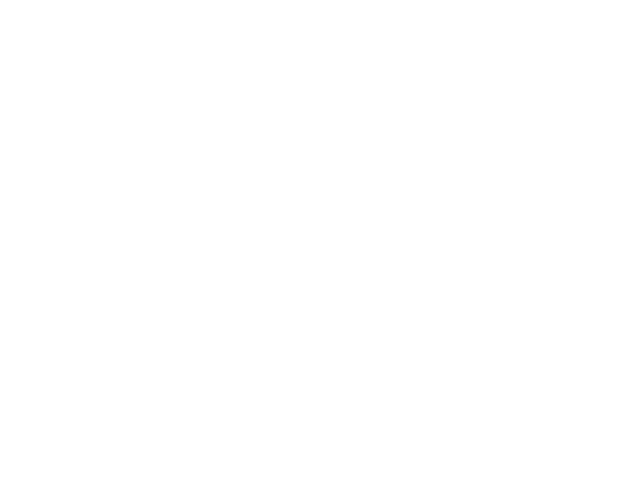

In [14]:
plan = plan_unit_test()

<IPython.core.display.Javascript object>


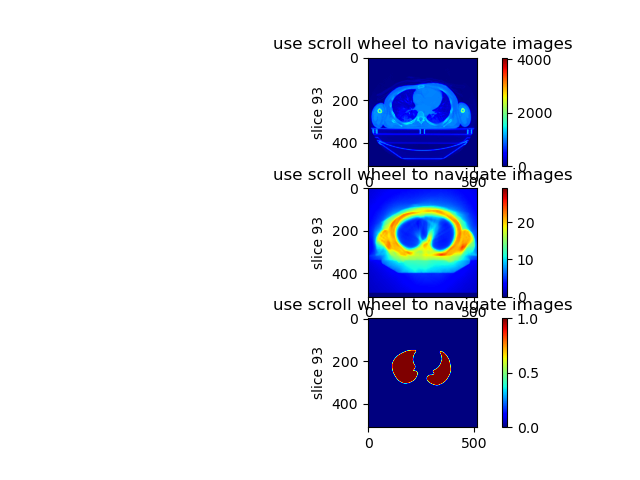

In [27]:
organ = 'Lungs'
fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
max_img = np.max(plan.img_volume.flatten())
max_dose = np.max(plan.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, plan.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
#tracker4 = IndexTracker(ax4, plan.structures[organ]['contour'], fig,0,1)
#fig.canvas.mpl_connect('scroll_event', tracker4.onscroll)
plt.show()

In [43]:
zmin_body,zmax_body,xmin_body,xmax_body,ymin_body,ymax_body = plan.structure_range('BODY')
section = 'Lungs'
zmin,zmax,xmin,xmax,ymin,ymax = plan.structure_range(section)

origin = [math.floor((zmin+zmax)/2), math.floor((xmin_body+xmax_body)/2), math.floor((ymin_body+ymax_body)/2)]

In [44]:
z_dim = int(section_size[0]*10 / plan.slice_thickness)
x_dim = int(section_size[1]*10 / plan.Row_Spacing); y_dim = int(section_size[2]*10 / plan.Col_Spacing)
plan_test = deepcopy(plan)
print(x_dim, y_dim, z_dim)
print(origin)

384 512 36
[98, 213, 249]


In [40]:
plan.Col_Spacing

0.976562

In [45]:
plan_test.img_cut(x_dim, y_dim, z_dim, origin)

<IPython.core.display.Javascript object>


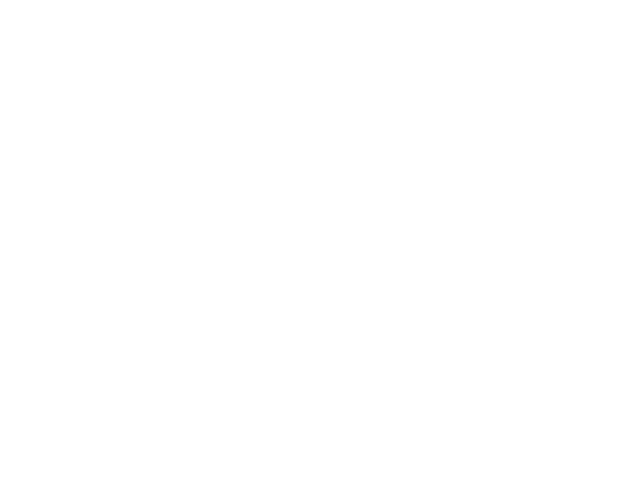

ValueError: zero-size array to reduction operation maximum which has no identity

In [46]:
organ = 'Lungs'
fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
max_img = np.max(plan_test.img_volume.flatten())
max_dose = np.max(plan_test.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan_test.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan_test.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, plan_test.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
#tracker4 = IndexTracker(ax4, plan.structures[organ]['contour'], fig,0,1)
#fig.canvas.mpl_connect('scroll_event', tracker4.onscroll)
plt.show()

In [20]:
scans, dose_imgs = get_plans_unit_test()

work on patient  TMI_Kane
work on RS structure  CT_TMI_11/18/19
start structure extraction
finish extract contour
Elapsed time: 124.2425 seconds
start extract dose
finish extract dose
Elapsed time: 38.7863 seconds
BODY <--------> BODY
PTV_Ribs <--------> PTV_Ribs
PTV_VExP <--------> PTV_VExP
PTV_SpCord <--------> PTV_SpCord
PTV_LN <--------> PTV_LN
PTV_Spleen <--------> PTV_Spleen
PTV_Liver <--------> PTV_Liver
Lungs <--------> Lungs
Heart <--------> Heart
Esophagus <--------> Esophagus
GI_Upper <--------> GI_Upper
one structure Mask Data Shape: (16, 64, 128, 12)
scan shape and dose shape= (1, 16, 64, 128, 12) (1, 16, 64, 128, 1)
Structure Masks Data Shape: (1, 16, 64, 128, 12)
Dose Data Shape: (1, 16, 64, 128, 1)
NPY dataset saved!
work on patient  TMI_Kane
work on RS structure  CT_TMI_11/18/19
start structure extraction
finish extract contour
Elapsed time: 135.4214 seconds
start extract dose
finish extract dose
Elapsed time: 38.6983 seconds
BODY <--------> BODY
PTV_Ribs <--------> PT

<IPython.core.display.Javascript object>


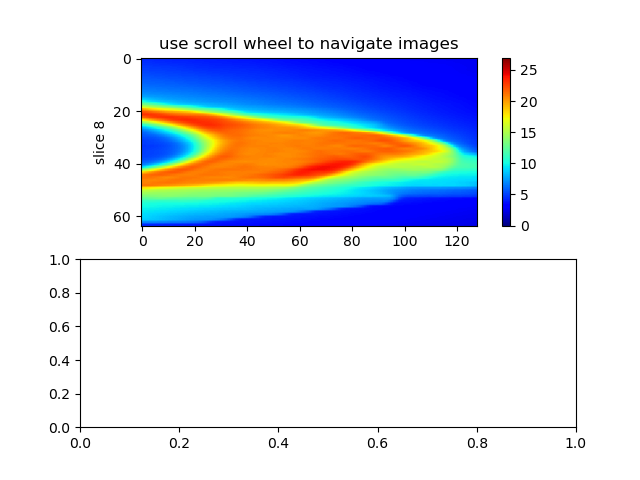

In [25]:
dose = np.squeeze(dose_imgs)
fig, (ax1, ax2)= plt.subplots(2, 1)
max_dose = np.max((dose).flatten())
tracker1 = IndexTracker(ax1, dose, fig,0,max_dose)

In [3]:
plan = pickle.load(open("plan_Chavez.pickle", "rb", -1))

<IPython.core.display.Javascript object>


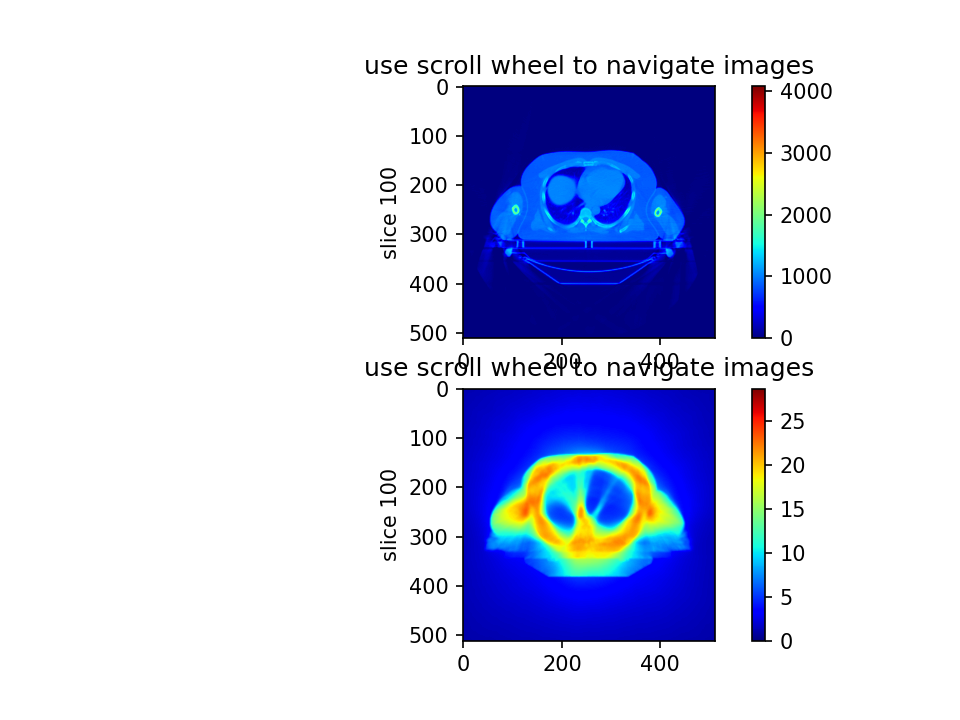

<IPython.core.display.Javascript object>


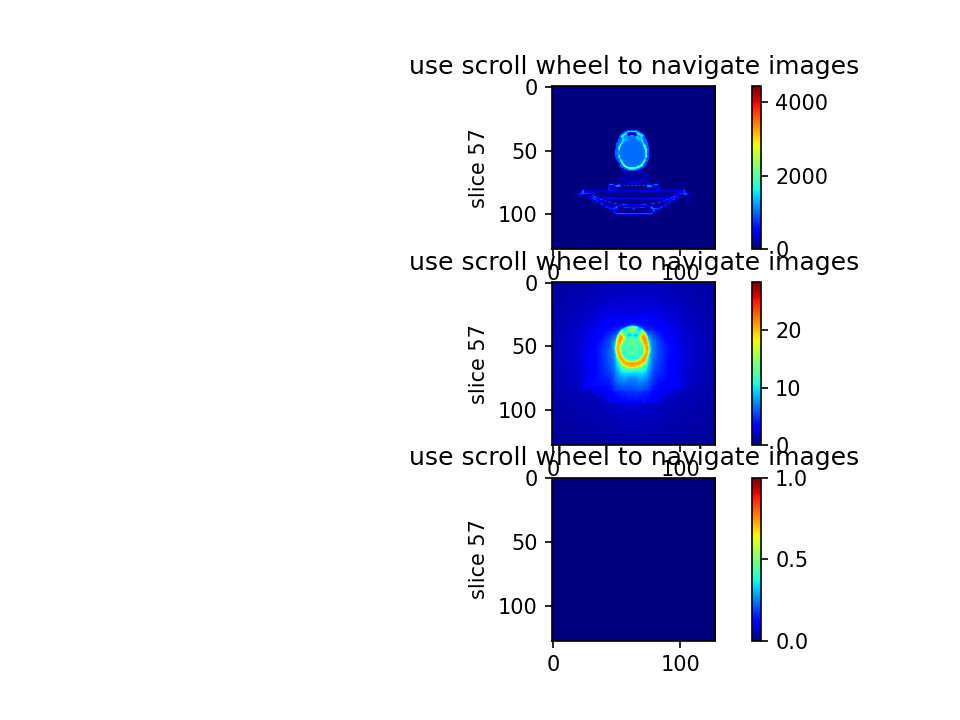

In [203]:
plan_new = deepcopy(plan)
plan_new = resample(plan_new,x_dim=128, y_dim=128, z_dim=64)
organ = 'Lungs'

print('old dimenstion is ', plan.img_volume.shape())
print('new dimenstion is ', plan_new.img_volume.shape())

fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
max_img = np.max(plan_new.img_volume.flatten())
max_dose = np.max(plan_new.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan_new.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan_new.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, plan_new.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
plt.show()

x_dim:122, y_dim:179, z_dim:29, origin:[104, 221, 255]


<IPython.core.display.Javascript object>


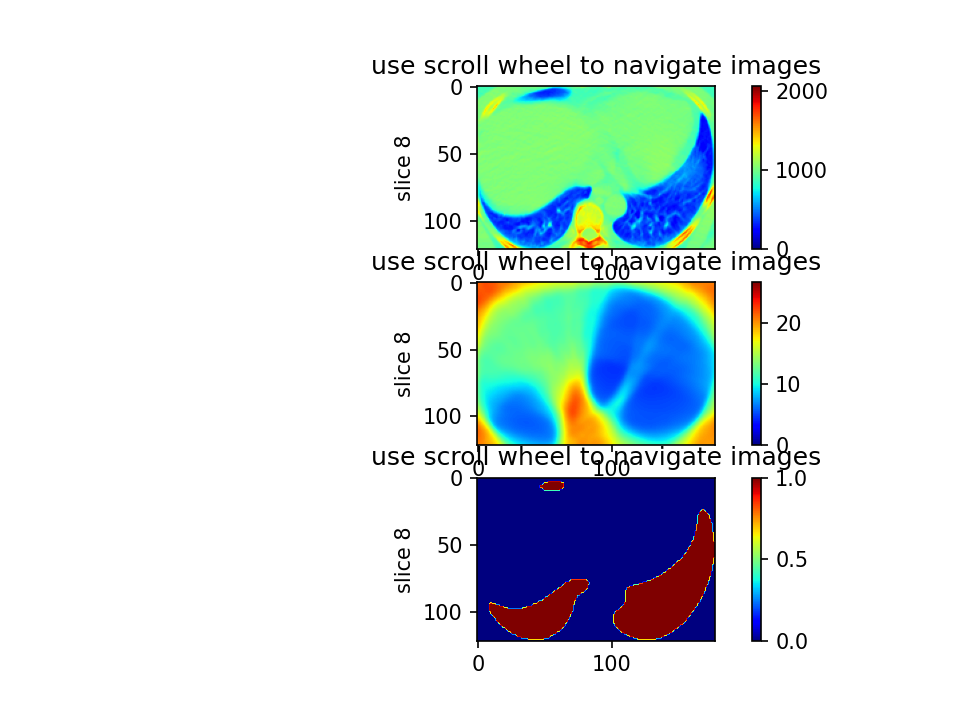

In [192]:
plan_new = deepcopy(plan)
zmin,zmax,xmin,xmax,ymin,ymax = structure_range(plan_new, 'Lungs')
origin = [math.floor((zmin+zmax)/2), math.floor((xmin+xmax)/2), math.floor((ymin+ymax)/2)]
x_dim = xmax-xmin+4; z_dim = zmax-zmin+4; y_dim = ymax-ymin+4
print('x_dim:{}, y_dim:{}, z_dim:{}, origin:{}'.format(x_dim,y_dim,z_dim,origin))
plan_new = img_cut(plan_new, x_dim, y_dim, z_dim, origin)
organ = 'Lungs'

fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
max_img = np.max(plan_new.img_volume.flatten())
max_dose = np.max(plan_new.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan_new.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan_new.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, plan_new.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
plt.show()

<IPython.core.display.Javascript object>


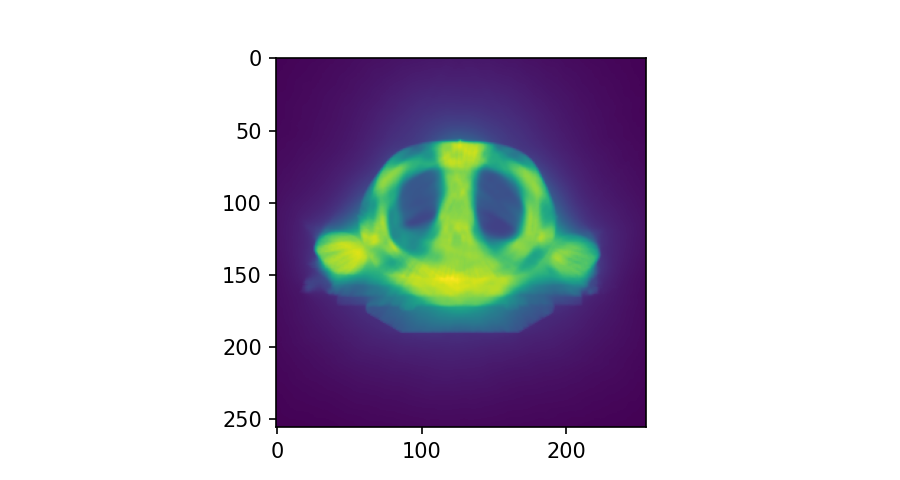

In [118]:
standard_list = ['PTV_Ribs', 'PTV_VExP', 'PTV_SpCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'BODY', 'Lungs']
standard_list = ['Heart', 'PTV_SpCord', 'Lung_L','PTV_Skull','Bladder']
plot_DVH(plan, standard_list)

Lungs
True mean organ dose is:  8.015882836100516
True max organ dose is:  26.72603736307324


<IPython.core.display.Javascript object>


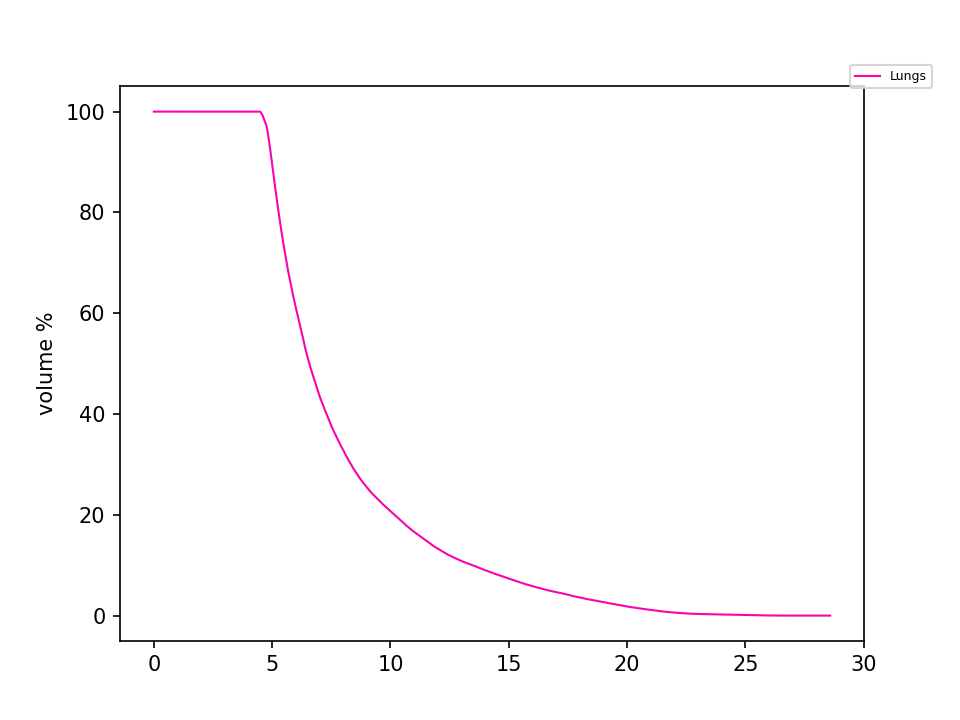

(defaultdict(None, {'Lungs': array([1., 1., 1., ..., 0., 0., 0.])}),
 {'Lungs': 8.015882836100516},
 {'Lungs': 26.72603736307324},
 {'Lungs': 4.847290374411494},
 {'Lungs': 16.67239108130915})

In [196]:
standard_list = ['PTV_Ribs', 'PTV_VExP', 'PTV_SpCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'BODY', 'Lungs']
standard_list = ['Lungs']
plot_DVH(plan, standard_list)

Lungs
True mean organ dose is:  7.988167042143717
True max organ dose is:  26.11972649371231


<IPython.core.display.Javascript object>


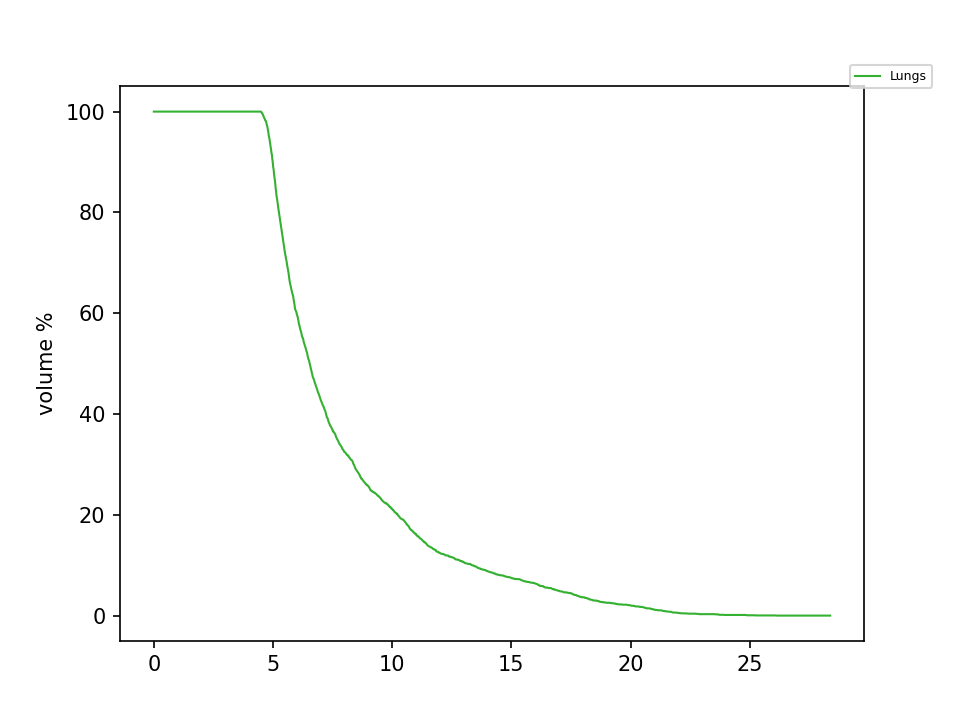

(defaultdict(None, {'Lungs': array([1., 1., 1., ..., 0., 0., 0.])}),
 {'Lungs': 7.988167042143717},
 {'Lungs': 26.11972649371231},
 {'Lungs': 4.840816918198047},
 {'Lungs': 16.92156529763071})

In [206]:
plot_DVH(plan_new, standard_list)

In [289]:
if __name__ == '__main__':
    run_training(train_gan_model = False, input_size = (16, 64, 128, 12), parent_path='Data', training_npy_path = 'Data/npy_dataset/training/' , validation_npy_path = 'Data/npy_dataset/validation/')

NameError: name 'run_training' is not defined

In [43]:
contour_arr_orignal = plan.structures['Ring_1']['contour']

In [54]:
x=np.array([1,2,3])
y=np.array([4,5,6])
z = np.array([7])
xx,yy, zz = np.meshgrid(x,y,z)

In [65]:
dose_plane = dose_vol.interpolating_function(test)

In [46]:
contour_arr_orignal = plan.structures['Ring_1']['contour'][107,:,:]

In [47]:
np.shape(contour_arr_orignal)

(640, 640)

In [67]:
np.shape(dose_plane)

(3, 3)

In [161]:
arrays = [np.random.randn(3, 4) for _ in range(5)]
np.stack(arrays, axis=0).shape
test = np.stack(arrays, axis=0)
test = test>0
test

array([[[ True, False, False, False],
        [False,  True,  True,  True],
        [False,  True,  True,  True]],

       [[False, False, False, False],
        [ True, False, False, False],
        [False,  True, False,  True]],

       [[False, False, False, False],
        [False,  True,  True, False],
        [False,  True, False, False]],

       [[False,  True,  True,  True],
        [False,  True,  True, False],
        [False,  True, False,  True]],

       [[ True, False,  True,  True],
        [ True, False, False, False],
        [False, False,  True,  True]]])

In [164]:
print(test.shape)
(x,y,z) = np.where(test)

(5, 3, 4)


In [5]:
x = np.array([1,2,3])
max(x-2,0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [274]:
y = 'abd'
y in x

False

In [250]:
data_folder = 'data_Chavez_NEW'
f = loadmat(data_folder)
scan = f['structset_2d_channel']
dose_img = f['doseset_2d']

In [251]:
scan.shape

(28, 128, 256, 13)

In [252]:
dose_img.shape

(28, 128, 256)

In [302]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.test.is_built_with_cuda()

False

In [10]:
training_unit_test()

output shape= (None, 16, 96, 128, 1)
Dose prediction Model Architecture:
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 16, 96, 128, 0                                            
__________________________________________________________________________________________________
conv3d_140 (Conv3D)             (None, 16, 96, 128,  5200        input_7[0][0]                    
__________________________________________________________________________________________________
concatenate_129 (Concatenate)   (None, 16, 96, 128,  0           input_7[0][0]                    
                                                                 conv3d_140[0][0]                 
__________________________________________________________________________________________________
conv3d_141 (C

Epoch 1/1000
2/2 [==============================] - ETA: 0s - loss: 140.5882 - mean_squared_error: 140.5882 - acc: 0.0000e+00
Epoch 00001: val_loss improved from inf to 136.82437, saving model to Data/Checkpoints_UnetDense\best_weights.h5
2/2 [==============================] - 3s 1s/step - loss: 140.5882 - mean_squared_error: 140.5882 - acc: 0.0000e+00 - val_loss: 136.8244 - val_mean_squared_error: 136.8244 - val_acc: 0.0000e+00
Epoch 2/1000
2/2 [==============================] - ETA: 0s - loss: 131.9485 - mean_squared_error: 131.9485 - acc: 0.0000e+00
Epoch 00002: val_loss improved from 136.82437 to 126.69785, saving model to Data/Checkpoints_UnetDense\best_weights.h5
2/2 [==============================] - 2s 1s/step - loss: 131.9485 - mean_squared_error: 131.9485 - acc: 0.0000e+00 - val_loss: 126.6978 - val_mean_squared_error: 126.6978 - val_acc: 0.0000e+00
Epoch 3/1000
2/2 [==============================] - ETA: 0s - loss: 115.5130 - mean_squared_error: 115.5130 - acc: 0.0000e+00
Ep

Epoch 22/1000
2/2 [==============================] - ETA: 0s - loss: 15.7369 - mean_squared_error: 15.7369 - acc: 0.0000e+00
Epoch 00022: val_loss did not improve from 27.18481
2/2 [==============================] - 2s 1s/step - loss: 15.7369 - mean_squared_error: 15.7369 - acc: 0.0000e+00 - val_loss: 29.0220 - val_mean_squared_error: 29.0220 - val_acc: 0.0000e+00
Epoch 23/1000
2/2 [==============================] - ETA: 0s - loss: 14.3924 - mean_squared_error: 14.3924 - acc: 0.0000e+00
Epoch 00023: val_loss did not improve from 27.18481
2/2 [==============================] - 2s 1s/step - loss: 14.3924 - mean_squared_error: 14.3924 - acc: 0.0000e+00 - val_loss: 30.7509 - val_mean_squared_error: 30.7509 - val_acc: 0.0000e+00
Epoch 24/1000
2/2 [==============================] - ETA: 0s - loss: 14.0234 - mean_squared_error: 14.0234 - acc: 0.0000e+00
Epoch 00024: val_loss did not improve from 27.18481
2/2 [==============================] - 2s 1s/step - loss: 14.0234 - mean_squared_error: 1

Epoch 42/1000
2/2 [==============================] - ETA: 0s - loss: 8.4561 - mean_squared_error: 8.4561 - acc: 0.0000e+00
Epoch 00042: val_loss improved from 17.84393 to 16.67243, saving model to Data/Checkpoints_UnetDense\best_weights.h5
2/2 [==============================] - 2s 1s/step - loss: 8.4561 - mean_squared_error: 8.4561 - acc: 0.0000e+00 - val_loss: 16.6724 - val_mean_squared_error: 16.6724 - val_acc: 0.0000e+00
Epoch 43/1000
2/2 [==============================] - ETA: 0s - loss: 8.3243 - mean_squared_error: 8.3243 - acc: 0.0000e+00
Epoch 00043: val_loss did not improve from 16.67243
2/2 [==============================] - 2s 1s/step - loss: 8.3243 - mean_squared_error: 8.3243 - acc: 0.0000e+00 - val_loss: 17.7897 - val_mean_squared_error: 17.7897 - val_acc: 0.0000e+00
Epoch 44/1000
2/2 [==============================] - ETA: 0s - loss: 8.1460 - mean_squared_error: 8.1460 - acc: 0.0000e+00
Epoch 00044: val_loss did not improve from 16.67243
2/2 [=============================

Epoch 63/1000
2/2 [==============================] - ETA: 0s - loss: 6.1571 - mean_squared_error: 6.1571 - acc: 0.0000e+00
Epoch 00063: val_loss did not improve from 12.20974
2/2 [==============================] - 2s 1s/step - loss: 6.1571 - mean_squared_error: 6.1571 - acc: 0.0000e+00 - val_loss: 12.9269 - val_mean_squared_error: 12.9269 - val_acc: 0.0000e+00
Epoch 64/1000
2/2 [==============================] - ETA: 0s - loss: 6.2417 - mean_squared_error: 6.2417 - acc: 0.0000e+00
Epoch 00064: val_loss did not improve from 12.20974
2/2 [==============================] - 2s 1s/step - loss: 6.2417 - mean_squared_error: 6.2417 - acc: 0.0000e+00 - val_loss: 13.4129 - val_mean_squared_error: 13.4129 - val_acc: 0.0000e+00
Epoch 65/1000
2/2 [==============================] - ETA: 0s - loss: 6.1538 - mean_squared_error: 6.1538 - acc: 0.0000e+00
Epoch 00065: val_loss improved from 12.20974 to 11.74839, saving model to Data/Checkpoints_UnetDense\best_weights.h5
2/2 [=============================

Epoch 85/1000
2/2 [==============================] - ETA: 0s - loss: 5.0318 - mean_squared_error: 5.0318 - acc: 0.0000e+00
Epoch 00085: val_loss improved from 10.76113 to 10.73546, saving model to Data/Checkpoints_UnetDense\best_weights.h5
2/2 [==============================] - 2s 1s/step - loss: 5.0318 - mean_squared_error: 5.0318 - acc: 0.0000e+00 - val_loss: 10.7355 - val_mean_squared_error: 10.7355 - val_acc: 0.0000e+00
Epoch 86/1000
2/2 [==============================] - ETA: 0s - loss: 4.8886 - mean_squared_error: 4.8886 - acc: 0.0000e+00
Epoch 00086: val_loss did not improve from 10.73546
2/2 [==============================] - 2s 1s/step - loss: 4.8886 - mean_squared_error: 4.8886 - acc: 0.0000e+00 - val_loss: 10.8187 - val_mean_squared_error: 10.8187 - val_acc: 0.0000e+00
Epoch 87/1000
2/2 [==============================] - ETA: 0s - loss: 4.8940 - mean_squared_error: 4.8940 - acc: 0.0000e+00
Epoch 00087: val_loss improved from 10.73546 to 10.54182, saving model to Data/Checkpo

Epoch 107/1000
2/2 [==============================] - ETA: 0s - loss: 4.1489 - mean_squared_error: 4.1489 - acc: 0.0000e+00
Epoch 00107: val_loss did not improve from 8.44641
2/2 [==============================] - 2s 1s/step - loss: 4.1489 - mean_squared_error: 4.1489 - acc: 0.0000e+00 - val_loss: 8.8336 - val_mean_squared_error: 8.8336 - val_acc: 0.0000e+00
Epoch 108/1000
2/2 [==============================] - ETA: 0s - loss: 3.9281 - mean_squared_error: 3.9281 - acc: 0.0000e+00
Epoch 00108: val_loss did not improve from 8.44641
2/2 [==============================] - 2s 1s/step - loss: 3.9281 - mean_squared_error: 3.9281 - acc: 0.0000e+00 - val_loss: 9.5096 - val_mean_squared_error: 9.5096 - val_acc: 0.0000e+00
Epoch 109/1000
2/2 [==============================] - ETA: 0s - loss: 4.1016 - mean_squared_error: 4.1016 - acc: 0.0000e+00
Epoch 00109: val_loss did not improve from 8.44641
2/2 [==============================] - 2s 1s/step - loss: 4.1016 - mean_squared_error: 4.1016 - acc: 0.

2/2 [==============================] - ETA: 0s - loss: 3.4658 - mean_squared_error: 3.4658 - acc: 0.0000e+00
Epoch 00129: val_loss did not improve from 7.80312
2/2 [==============================] - 2s 1s/step - loss: 3.4658 - mean_squared_error: 3.4658 - acc: 0.0000e+00 - val_loss: 7.9455 - val_mean_squared_error: 7.9455 - val_acc: 0.0000e+00
Epoch 130/1000
2/2 [==============================] - ETA: 0s - loss: 3.4745 - mean_squared_error: 3.4745 - acc: 0.0000e+00
Epoch 00130: val_loss did not improve from 7.80312
2/2 [==============================] - 2s 1s/step - loss: 3.4745 - mean_squared_error: 3.4745 - acc: 0.0000e+00 - val_loss: 7.8786 - val_mean_squared_error: 7.8786 - val_acc: 0.0000e+00
Epoch 131/1000
2/2 [==============================] - ETA: 0s - loss: 3.4051 - mean_squared_error: 3.4051 - acc: 0.0000e+00
Epoch 00131: val_loss did not improve from 7.80312
2/2 [==============================] - 2s 1s/step - loss: 3.4051 - mean_squared_error: 3.4051 - acc: 0.0000e+00 - val_

2/2 [==============================] - ETA: 0s - loss: 3.1184 - mean_squared_error: 3.1184 - acc: 0.0000e+00
Epoch 00151: val_loss did not improve from 6.48739
2/2 [==============================] - 2s 1s/step - loss: 3.1184 - mean_squared_error: 3.1184 - acc: 0.0000e+00 - val_loss: 7.3873 - val_mean_squared_error: 7.3873 - val_acc: 0.0000e+00
Epoch 152/1000
2/2 [==============================] - ETA: 0s - loss: 3.0608 - mean_squared_error: 3.0608 - acc: 0.0000e+00
Epoch 00152: val_loss did not improve from 6.48739
2/2 [==============================] - 2s 1s/step - loss: 3.0608 - mean_squared_error: 3.0608 - acc: 0.0000e+00 - val_loss: 6.8139 - val_mean_squared_error: 6.8139 - val_acc: 0.0000e+00
Epoch 153/1000
2/2 [==============================] - ETA: 0s - loss: 2.9864 - mean_squared_error: 2.9864 - acc: 0.0000e+00
Epoch 00153: val_loss did not improve from 6.48739
2/2 [==============================] - 2s 1s/step - loss: 2.9864 - mean_squared_error: 2.9864 - acc: 0.0000e+00 - val_

2/2 [==============================] - ETA: 0s - loss: 2.7063 - mean_squared_error: 2.7063 - acc: 0.0000e+00
Epoch 00173: val_loss did not improve from 5.82167
2/2 [==============================] - 2s 1s/step - loss: 2.7063 - mean_squared_error: 2.7063 - acc: 0.0000e+00 - val_loss: 6.7220 - val_mean_squared_error: 6.7220 - val_acc: 0.0000e+00
Epoch 174/1000
2/2 [==============================] - ETA: 0s - loss: 2.6961 - mean_squared_error: 2.6961 - acc: 0.0000e+00
Epoch 00174: val_loss did not improve from 5.82167
2/2 [==============================] - 2s 1s/step - loss: 2.6961 - mean_squared_error: 2.6961 - acc: 0.0000e+00 - val_loss: 6.3343 - val_mean_squared_error: 6.3343 - val_acc: 0.0000e+00
Epoch 175/1000
2/2 [==============================] - ETA: 0s - loss: 2.6883 - mean_squared_error: 2.6883 - acc: 0.0000e+00
Epoch 00175: val_loss did not improve from 5.82167
2/2 [==============================] - 2s 1s/step - loss: 2.6883 - mean_squared_error: 2.6883 - acc: 0.0000e+00 - val_

2/2 [==============================] - ETA: 0s - loss: 2.4999 - mean_squared_error: 2.4999 - acc: 0.0000e+00
Epoch 00195: val_loss did not improve from 5.02482
2/2 [==============================] - 2s 1s/step - loss: 2.4999 - mean_squared_error: 2.4999 - acc: 0.0000e+00 - val_loss: 6.5222 - val_mean_squared_error: 6.5222 - val_acc: 0.0000e+00
Epoch 196/1000
2/2 [==============================] - ETA: 0s - loss: 2.5442 - mean_squared_error: 2.5442 - acc: 0.0000e+00
Epoch 00196: val_loss improved from 5.02482 to 4.99598, saving model to Data/Checkpoints_UnetDense\best_weights.h5
2/2 [==============================] - 2s 1s/step - loss: 2.5442 - mean_squared_error: 2.5442 - acc: 0.0000e+00 - val_loss: 4.9960 - val_mean_squared_error: 4.9960 - val_acc: 0.0000e+00
Epoch 197/1000
2/2 [==============================] - ETA: 0s - loss: 2.6760 - mean_squared_error: 2.6760 - acc: 0.0000e+00
Epoch 00197: val_loss did not improve from 4.99598
2/2 [==============================] - 2s 1s/step - lo

Epoch 218/1000
2/2 [==============================] - ETA: 0s - loss: 2.2805 - mean_squared_error: 2.2805 - acc: 0.0000e+00
Epoch 00218: val_loss did not improve from 4.65450
2/2 [==============================] - 2s 1s/step - loss: 2.2805 - mean_squared_error: 2.2805 - acc: 0.0000e+00 - val_loss: 4.8900 - val_mean_squared_error: 4.8900 - val_acc: 0.0000e+00
Epoch 219/1000
2/2 [==============================] - ETA: 0s - loss: 2.2709 - mean_squared_error: 2.2709 - acc: 0.0000e+00
Epoch 00219: val_loss did not improve from 4.65450
2/2 [==============================] - 2s 1s/step - loss: 2.2709 - mean_squared_error: 2.2709 - acc: 0.0000e+00 - val_loss: 5.5310 - val_mean_squared_error: 5.5310 - val_acc: 0.0000e+00
Epoch 220/1000
2/2 [==============================] - ETA: 0s - loss: 2.2328 - mean_squared_error: 2.2328 - acc: 0.0000e+00
Epoch 00220: val_loss did not improve from 4.65450
2/2 [==============================] - 2s 1s/step - loss: 2.2328 - mean_squared_error: 2.2328 - acc: 0.

Epoch 241/1000
2/2 [==============================] - ETA: 0s - loss: 2.0222 - mean_squared_error: 2.0222 - acc: 0.0000e+00
Epoch 00241: val_loss did not improve from 4.37855
2/2 [==============================] - 2s 1s/step - loss: 2.0222 - mean_squared_error: 2.0222 - acc: 0.0000e+00 - val_loss: 4.9155 - val_mean_squared_error: 4.9155 - val_acc: 0.0000e+00
Epoch 242/1000
2/2 [==============================] - ETA: 0s - loss: 2.0502 - mean_squared_error: 2.0502 - acc: 0.0000e+00
Epoch 00242: val_loss did not improve from 4.37855
2/2 [==============================] - 2s 1s/step - loss: 2.0502 - mean_squared_error: 2.0502 - acc: 0.0000e+00 - val_loss: 5.1305 - val_mean_squared_error: 5.1305 - val_acc: 0.0000e+00
Epoch 243/1000
2/2 [==============================] - ETA: 0s - loss: 2.0337 - mean_squared_error: 2.0337 - acc: 0.0000e+00
Epoch 00243: val_loss did not improve from 4.37855
2/2 [==============================] - 2s 1s/step - loss: 2.0337 - mean_squared_error: 2.0337 - acc: 0.

2/2 [==============================] - ETA: 0s - loss: 1.9759 - mean_squared_error: 1.9759 - acc: 0.0000e+00
Epoch 00263: val_loss did not improve from 3.79934
2/2 [==============================] - 2s 1s/step - loss: 1.9759 - mean_squared_error: 1.9759 - acc: 0.0000e+00 - val_loss: 4.1283 - val_mean_squared_error: 4.1283 - val_acc: 0.0000e+00
Epoch 264/1000
2/2 [==============================] - ETA: 0s - loss: 1.9573 - mean_squared_error: 1.9573 - acc: 0.0000e+00
Epoch 00264: val_loss did not improve from 3.79934
2/2 [==============================] - 2s 1s/step - loss: 1.9573 - mean_squared_error: 1.9573 - acc: 0.0000e+00 - val_loss: 4.4190 - val_mean_squared_error: 4.4190 - val_acc: 0.0000e+00
Epoch 265/1000
2/2 [==============================] - ETA: 0s - loss: 1.9524 - mean_squared_error: 1.9524 - acc: 0.0000e+00
Epoch 00265: val_loss did not improve from 3.79934
2/2 [==============================] - 2s 1s/step - loss: 1.9524 - mean_squared_error: 1.9524 - acc: 0.0000e+00 - val_

Epoch 286/1000
2/2 [==============================] - ETA: 0s - loss: 1.8643 - mean_squared_error: 1.8643 - acc: 0.0000e+00
Epoch 00286: val_loss did not improve from 3.54052
2/2 [==============================] - 2s 1s/step - loss: 1.8643 - mean_squared_error: 1.8643 - acc: 0.0000e+00 - val_loss: 4.1973 - val_mean_squared_error: 4.1973 - val_acc: 0.0000e+00
Epoch 287/1000
2/2 [==============================] - ETA: 0s - loss: 1.7906 - mean_squared_error: 1.7906 - acc: 0.0000e+00
Epoch 00287: val_loss did not improve from 3.54052
2/2 [==============================] - 2s 1s/step - loss: 1.7906 - mean_squared_error: 1.7906 - acc: 0.0000e+00 - val_loss: 3.8798 - val_mean_squared_error: 3.8798 - val_acc: 0.0000e+00
Epoch 288/1000
2/2 [==============================] - ETA: 0s - loss: 1.7819 - mean_squared_error: 1.7819 - acc: 0.0000e+00
Epoch 00288: val_loss did not improve from 3.54052
2/2 [==============================] - 2s 1s/step - loss: 1.7819 - mean_squared_error: 1.7819 - acc: 0.

2/2 [==============================] - ETA: 0s - loss: 1.8516 - mean_squared_error: 1.8516 - acc: 0.0000e+00
Epoch 00308: val_loss did not improve from 3.05711
2/2 [==============================] - 2s 1s/step - loss: 1.8516 - mean_squared_error: 1.8516 - acc: 0.0000e+00 - val_loss: 4.2273 - val_mean_squared_error: 4.2273 - val_acc: 0.0000e+00
Epoch 309/1000
2/2 [==============================] - ETA: 0s - loss: 1.7414 - mean_squared_error: 1.7414 - acc: 0.0000e+00
Epoch 00309: val_loss did not improve from 3.05711
2/2 [==============================] - 2s 1s/step - loss: 1.7414 - mean_squared_error: 1.7414 - acc: 0.0000e+00 - val_loss: 4.1591 - val_mean_squared_error: 4.1591 - val_acc: 0.0000e+00
Epoch 310/1000
2/2 [==============================] - ETA: 0s - loss: 1.7422 - mean_squared_error: 1.7422 - acc: 0.0000e+00
Epoch 00310: val_loss did not improve from 3.05711
2/2 [==============================] - 2s 1s/step - loss: 1.7422 - mean_squared_error: 1.7422 - acc: 0.0000e+00 - val_

Epoch 331/1000
2/2 [==============================] - ETA: 0s - loss: 1.6405 - mean_squared_error: 1.6405 - acc: 0.0000e+00
Epoch 00331: val_loss did not improve from 3.00768
2/2 [==============================] - 2s 1s/step - loss: 1.6405 - mean_squared_error: 1.6405 - acc: 0.0000e+00 - val_loss: 4.1189 - val_mean_squared_error: 4.1189 - val_acc: 0.0000e+00
Epoch 332/1000
2/2 [==============================] - ETA: 0s - loss: 1.5932 - mean_squared_error: 1.5932 - acc: 0.0000e+00
Epoch 00332: val_loss did not improve from 3.00768
2/2 [==============================] - 2s 1s/step - loss: 1.5932 - mean_squared_error: 1.5932 - acc: 0.0000e+00 - val_loss: 3.1209 - val_mean_squared_error: 3.1209 - val_acc: 0.0000e+00
Epoch 333/1000
2/2 [==============================] - ETA: 0s - loss: 1.6848 - mean_squared_error: 1.6848 - acc: 0.0000e+00
Epoch 00333: val_loss did not improve from 3.00768
2/2 [==============================] - 2s 1s/step - loss: 1.6848 - mean_squared_error: 1.6848 - acc: 0.

2/2 [==============================] - ETA: 0s - loss: 1.5254 - mean_squared_error: 1.5254 - acc: 0.0000e+00
Epoch 00353: val_loss did not improve from 2.83656
2/2 [==============================] - 2s 1s/step - loss: 1.5254 - mean_squared_error: 1.5254 - acc: 0.0000e+00 - val_loss: 3.1739 - val_mean_squared_error: 3.1739 - val_acc: 0.0000e+00
Epoch 354/1000
2/2 [==============================] - ETA: 0s - loss: 1.4664 - mean_squared_error: 1.4664 - acc: 0.0000e+00
Epoch 00354: val_loss did not improve from 2.83656
2/2 [==============================] - 2s 1s/step - loss: 1.4664 - mean_squared_error: 1.4664 - acc: 0.0000e+00 - val_loss: 3.0775 - val_mean_squared_error: 3.0775 - val_acc: 0.0000e+00
Epoch 355/1000
2/2 [==============================] - ETA: 0s - loss: 1.4725 - mean_squared_error: 1.4725 - acc: 0.0000e+00
Epoch 00355: val_loss did not improve from 2.83656
2/2 [==============================] - 2s 1s/step - loss: 1.4725 - mean_squared_error: 1.4725 - acc: 0.0000e+00 - val_

Epoch 376/1000
2/2 [==============================] - ETA: 0s - loss: 1.4463 - mean_squared_error: 1.4463 - acc: 0.0000e+00
Epoch 00376: val_loss did not improve from 2.53352
2/2 [==============================] - 2s 1s/step - loss: 1.4463 - mean_squared_error: 1.4463 - acc: 0.0000e+00 - val_loss: 3.6684 - val_mean_squared_error: 3.6684 - val_acc: 0.0000e+00
Epoch 377/1000
2/2 [==============================] - ETA: 0s - loss: 1.6172 - mean_squared_error: 1.6172 - acc: 0.0000e+00
Epoch 00377: val_loss did not improve from 2.53352
2/2 [==============================] - 2s 1s/step - loss: 1.6172 - mean_squared_error: 1.6172 - acc: 0.0000e+00 - val_loss: 2.8110 - val_mean_squared_error: 2.8110 - val_acc: 0.0000e+00
Epoch 378/1000
2/2 [==============================] - ETA: 0s - loss: 1.5212 - mean_squared_error: 1.5212 - acc: 0.0000e+00
Epoch 00378: val_loss did not improve from 2.53352
2/2 [==============================] - 2s 1s/step - loss: 1.5212 - mean_squared_error: 1.5212 - acc: 0.

2/2 [==============================] - ETA: 0s - loss: 1.3654 - mean_squared_error: 1.3654 - acc: 0.0000e+00
Epoch 00398: val_loss did not improve from 2.43058
2/2 [==============================] - 2s 1s/step - loss: 1.3654 - mean_squared_error: 1.3654 - acc: 0.0000e+00 - val_loss: 3.0774 - val_mean_squared_error: 3.0774 - val_acc: 0.0000e+00
Epoch 399/1000
2/2 [==============================] - ETA: 0s - loss: 1.3778 - mean_squared_error: 1.3778 - acc: 0.0000e+00
Epoch 00399: val_loss improved from 2.43058 to 2.38390, saving model to Data/Checkpoints_UnetDense\best_weights.h5
2/2 [==============================] - 2s 1s/step - loss: 1.3778 - mean_squared_error: 1.3778 - acc: 0.0000e+00 - val_loss: 2.3839 - val_mean_squared_error: 2.3839 - val_acc: 0.0000e+00
Epoch 400/1000
2/2 [==============================] - ETA: 0s - loss: 1.4582 - mean_squared_error: 1.4582 - acc: 0.0000e+00
Epoch 00400: val_loss did not improve from 2.38390
2/2 [==============================] - 2s 1s/step - lo

Epoch 421/1000
2/2 [==============================] - ETA: 0s - loss: 1.3145 - mean_squared_error: 1.3145 - acc: 0.0000e+00
Epoch 00421: val_loss did not improve from 2.38390
2/2 [==============================] - 2s 1s/step - loss: 1.3145 - mean_squared_error: 1.3145 - acc: 0.0000e+00 - val_loss: 2.7237 - val_mean_squared_error: 2.7237 - val_acc: 0.0000e+00
Epoch 422/1000
2/2 [==============================] - ETA: 0s - loss: 1.3211 - mean_squared_error: 1.3211 - acc: 0.0000e+00
Epoch 00422: val_loss did not improve from 2.38390
2/2 [==============================] - 2s 1s/step - loss: 1.3211 - mean_squared_error: 1.3211 - acc: 0.0000e+00 - val_loss: 2.6101 - val_mean_squared_error: 2.6101 - val_acc: 0.0000e+00
Epoch 423/1000
2/2 [==============================] - ETA: 0s - loss: 1.3355 - mean_squared_error: 1.3355 - acc: 0.0000e+00
Epoch 00423: val_loss improved from 2.38390 to 2.33931, saving model to Data/Checkpoints_UnetDense\best_weights.h5
2/2 [==============================] - 

Epoch 443/1000
2/2 [==============================] - ETA: 0s - loss: 1.2942 - mean_squared_error: 1.2942 - acc: 0.0000e+00
Epoch 00443: val_loss did not improve from 1.98753
2/2 [==============================] - 2s 1s/step - loss: 1.2942 - mean_squared_error: 1.2942 - acc: 0.0000e+00 - val_loss: 3.0554 - val_mean_squared_error: 3.0554 - val_acc: 0.0000e+00
Epoch 444/1000
2/2 [==============================] - ETA: 0s - loss: 1.3021 - mean_squared_error: 1.3021 - acc: 0.0000e+00
Epoch 00444: val_loss did not improve from 1.98753
2/2 [==============================] - 2s 1s/step - loss: 1.3021 - mean_squared_error: 1.3021 - acc: 0.0000e+00 - val_loss: 2.5290 - val_mean_squared_error: 2.5290 - val_acc: 0.0000e+00
Epoch 445/1000
2/2 [==============================] - ETA: 0s - loss: 1.2581 - mean_squared_error: 1.2581 - acc: 0.0000e+00
Epoch 00445: val_loss did not improve from 1.98753
2/2 [==============================] - 2s 1s/step - loss: 1.2581 - mean_squared_error: 1.2581 - acc: 0.

Epoch 466/1000
2/2 [==============================] - ETA: 0s - loss: 1.1682 - mean_squared_error: 1.1682 - acc: 0.0000e+00
Epoch 00466: val_loss did not improve from 1.98753
2/2 [==============================] - 2s 1s/step - loss: 1.1682 - mean_squared_error: 1.1682 - acc: 0.0000e+00 - val_loss: 2.0150 - val_mean_squared_error: 2.0150 - val_acc: 0.0000e+00
Epoch 467/1000
2/2 [==============================] - ETA: 0s - loss: 1.1994 - mean_squared_error: 1.1994 - acc: 0.0000e+00
Epoch 00467: val_loss did not improve from 1.98753
2/2 [==============================] - 2s 1s/step - loss: 1.1994 - mean_squared_error: 1.1994 - acc: 0.0000e+00 - val_loss: 2.7178 - val_mean_squared_error: 2.7178 - val_acc: 0.0000e+00
Epoch 468/1000
2/2 [==============================] - ETA: 0s - loss: 1.2682 - mean_squared_error: 1.2682 - acc: 0.0000e+00
Epoch 00468: val_loss did not improve from 1.98753
2/2 [==============================] - 2s 1s/step - loss: 1.2682 - mean_squared_error: 1.2682 - acc: 0.

2/2 [==============================] - ETA: 0s - loss: 1.1537 - mean_squared_error: 1.1537 - acc: 0.0000e+00
Epoch 00488: val_loss did not improve from 1.84318
2/2 [==============================] - 2s 1s/step - loss: 1.1537 - mean_squared_error: 1.1537 - acc: 0.0000e+00 - val_loss: 2.2226 - val_mean_squared_error: 2.2226 - val_acc: 0.0000e+00
Epoch 489/1000
2/2 [==============================] - ETA: 0s - loss: 1.1831 - mean_squared_error: 1.1831 - acc: 0.0000e+00
Epoch 00489: val_loss did not improve from 1.84318
2/2 [==============================] - 2s 1s/step - loss: 1.1831 - mean_squared_error: 1.1831 - acc: 0.0000e+00 - val_loss: 2.2424 - val_mean_squared_error: 2.2424 - val_acc: 0.0000e+00
Epoch 490/1000
2/2 [==============================] - ETA: 0s - loss: 1.1484 - mean_squared_error: 1.1484 - acc: 0.0000e+00
Epoch 00490: val_loss did not improve from 1.84318
2/2 [==============================] - 2s 1s/step - loss: 1.1484 - mean_squared_error: 1.1484 - acc: 0.0000e+00 - val_

Epoch 511/1000
2/2 [==============================] - ETA: 0s - loss: 1.0859 - mean_squared_error: 1.0859 - acc: 0.0000e+00
Epoch 00511: val_loss improved from 1.82413 to 1.73697, saving model to Data/Checkpoints_UnetDense\best_weights.h5
2/2 [==============================] - 2s 1s/step - loss: 1.0859 - mean_squared_error: 1.0859 - acc: 0.0000e+00 - val_loss: 1.7370 - val_mean_squared_error: 1.7370 - val_acc: 0.0000e+00
Epoch 512/1000
2/2 [==============================] - ETA: 0s - loss: 1.1435 - mean_squared_error: 1.1435 - acc: 0.0000e+00
Epoch 00512: val_loss did not improve from 1.73697
2/2 [==============================] - 2s 1s/step - loss: 1.1435 - mean_squared_error: 1.1435 - acc: 0.0000e+00 - val_loss: 2.2945 - val_mean_squared_error: 2.2945 - val_acc: 0.0000e+00
Epoch 513/1000
2/2 [==============================] - ETA: 0s - loss: 1.1206 - mean_squared_error: 1.1206 - acc: 0.0000e+00
Epoch 00513: val_loss did not improve from 1.73697
2/2 [==============================] - 

2/2 [==============================] - ETA: 0s - loss: 1.0877 - mean_squared_error: 1.0877 - acc: 0.0000e+00
Epoch 00533: val_loss did not improve from 1.70951
2/2 [==============================] - 2s 1s/step - loss: 1.0877 - mean_squared_error: 1.0877 - acc: 0.0000e+00 - val_loss: 2.0890 - val_mean_squared_error: 2.0890 - val_acc: 0.0000e+00
Epoch 534/1000
2/2 [==============================] - ETA: 0s - loss: 1.0843 - mean_squared_error: 1.0843 - acc: 0.0000e+00
Epoch 00534: val_loss improved from 1.70951 to 1.63613, saving model to Data/Checkpoints_UnetDense\best_weights.h5
2/2 [==============================] - 2s 1s/step - loss: 1.0843 - mean_squared_error: 1.0843 - acc: 0.0000e+00 - val_loss: 1.6361 - val_mean_squared_error: 1.6361 - val_acc: 0.0000e+00
Epoch 535/1000
2/2 [==============================] - ETA: 0s - loss: 1.0982 - mean_squared_error: 1.0982 - acc: 0.0000e+00
Epoch 00535: val_loss did not improve from 1.63613
2/2 [==============================] - 2s 1s/step - lo

2/2 [==============================] - ETA: 0s - loss: 1.0386 - mean_squared_error: 1.0386 - acc: 0.0000e+00
Epoch 00555: val_loss did not improve from 1.47970
2/2 [==============================] - 2s 1s/step - loss: 1.0386 - mean_squared_error: 1.0386 - acc: 0.0000e+00 - val_loss: 1.7261 - val_mean_squared_error: 1.7261 - val_acc: 0.0000e+00
Epoch 556/1000
2/2 [==============================] - ETA: 0s - loss: 1.0581 - mean_squared_error: 1.0581 - acc: 0.0000e+00
Epoch 00556: val_loss did not improve from 1.47970
2/2 [==============================] - 2s 1s/step - loss: 1.0581 - mean_squared_error: 1.0581 - acc: 0.0000e+00 - val_loss: 2.0163 - val_mean_squared_error: 2.0163 - val_acc: 0.0000e+00
Epoch 557/1000
2/2 [==============================] - ETA: 0s - loss: 1.0001 - mean_squared_error: 1.0001 - acc: 0.0000e+00
Epoch 00557: val_loss did not improve from 1.47970
2/2 [==============================] - 2s 1s/step - loss: 1.0001 - mean_squared_error: 1.0001 - acc: 0.0000e+00 - val_

Epoch 578/1000
2/2 [==============================] - ETA: 0s - loss: 0.9720 - mean_squared_error: 0.9720 - acc: 0.0000e+00
Epoch 00578: val_loss did not improve from 1.39626
2/2 [==============================] - 2s 1s/step - loss: 0.9720 - mean_squared_error: 0.9720 - acc: 0.0000e+00 - val_loss: 1.8023 - val_mean_squared_error: 1.8023 - val_acc: 0.0000e+00
Epoch 579/1000
2/2 [==============================] - ETA: 0s - loss: 1.0100 - mean_squared_error: 1.0100 - acc: 0.0000e+00
Epoch 00579: val_loss did not improve from 1.39626
2/2 [==============================] - 2s 1s/step - loss: 1.0100 - mean_squared_error: 1.0100 - acc: 0.0000e+00 - val_loss: 1.7722 - val_mean_squared_error: 1.7722 - val_acc: 0.0000e+00
Epoch 580/1000
2/2 [==============================] - ETA: 0s - loss: 0.9839 - mean_squared_error: 0.9839 - acc: 0.0000e+00
Epoch 00580: val_loss did not improve from 1.39626
2/2 [==============================] - 2s 1s/step - loss: 0.9839 - mean_squared_error: 0.9839 - acc: 0.

Epoch 601/1000
2/2 [==============================] - ETA: 0s - loss: 0.9443 - mean_squared_error: 0.9443 - acc: 0.0000e+00
Epoch 00601: val_loss did not improve from 1.39626
2/2 [==============================] - 2s 1s/step - loss: 0.9443 - mean_squared_error: 0.9443 - acc: 0.0000e+00 - val_loss: 1.5006 - val_mean_squared_error: 1.5006 - val_acc: 0.0000e+00
Epoch 602/1000
2/2 [==============================] - ETA: 0s - loss: 0.9357 - mean_squared_error: 0.9357 - acc: 0.0000e+00
Epoch 00602: val_loss did not improve from 1.39626
2/2 [==============================] - 2s 1s/step - loss: 0.9357 - mean_squared_error: 0.9357 - acc: 0.0000e+00 - val_loss: 1.9091 - val_mean_squared_error: 1.9091 - val_acc: 0.0000e+00
Epoch 603/1000
2/2 [==============================] - ETA: 0s - loss: 0.9426 - mean_squared_error: 0.9426 - acc: 0.0000e+00
Epoch 00603: val_loss did not improve from 1.39626
2/2 [==============================] - 2s 1s/step - loss: 0.9426 - mean_squared_error: 0.9426 - acc: 0.

Epoch 624/1000
2/2 [==============================] - ETA: 0s - loss: 0.9217 - mean_squared_error: 0.9217 - acc: 0.0000e+00
Epoch 00624: val_loss did not improve from 1.36744
2/2 [==============================] - 2s 1s/step - loss: 0.9217 - mean_squared_error: 0.9217 - acc: 0.0000e+00 - val_loss: 1.6544 - val_mean_squared_error: 1.6544 - val_acc: 0.0000e+00
Epoch 625/1000
2/2 [==============================] - ETA: 0s - loss: 0.9204 - mean_squared_error: 0.9204 - acc: 0.0000e+00
Epoch 00625: val_loss did not improve from 1.36744
2/2 [==============================] - 2s 1s/step - loss: 0.9204 - mean_squared_error: 0.9204 - acc: 0.0000e+00 - val_loss: 1.5650 - val_mean_squared_error: 1.5650 - val_acc: 0.0000e+00
Epoch 626/1000
2/2 [==============================] - ETA: 0s - loss: 0.9073 - mean_squared_error: 0.9073 - acc: 0.0000e+00
Epoch 00626: val_loss did not improve from 1.36744
2/2 [==============================] - 2s 1s/step - loss: 0.9073 - mean_squared_error: 0.9073 - acc: 0.

Epoch 647/1000
2/2 [==============================] - ETA: 0s - loss: 0.8880 - mean_squared_error: 0.8880 - acc: 0.0000e+00
Epoch 00647: val_loss did not improve from 1.36744
2/2 [==============================] - 2s 1s/step - loss: 0.8880 - mean_squared_error: 0.8880 - acc: 0.0000e+00 - val_loss: 1.4761 - val_mean_squared_error: 1.4761 - val_acc: 0.0000e+00
Epoch 648/1000
2/2 [==============================] - ETA: 0s - loss: 0.8829 - mean_squared_error: 0.8829 - acc: 0.0000e+00
Epoch 00648: val_loss did not improve from 1.36744
2/2 [==============================] - 2s 1s/step - loss: 0.8829 - mean_squared_error: 0.8829 - acc: 0.0000e+00 - val_loss: 1.6749 - val_mean_squared_error: 1.6749 - val_acc: 0.0000e+00
Epoch 649/1000
2/2 [==============================] - ETA: 0s - loss: 0.8876 - mean_squared_error: 0.8876 - acc: 0.0000e+00
Epoch 00649: val_loss did not improve from 1.36744
2/2 [==============================] - 2s 1s/step - loss: 0.8876 - mean_squared_error: 0.8876 - acc: 0.

2/2 [==============================] - ETA: 0s - loss: 0.8682 - mean_squared_error: 0.8682 - acc: 0.0000e+00
Epoch 00669: val_loss did not improve from 1.14701
2/2 [==============================] - 2s 1s/step - loss: 0.8682 - mean_squared_error: 0.8682 - acc: 0.0000e+00 - val_loss: 1.4312 - val_mean_squared_error: 1.4312 - val_acc: 0.0000e+00
Epoch 670/1000
2/2 [==============================] - ETA: 0s - loss: 0.8675 - mean_squared_error: 0.8675 - acc: 0.0000e+00
Epoch 00670: val_loss did not improve from 1.14701
2/2 [==============================] - 2s 1s/step - loss: 0.8675 - mean_squared_error: 0.8675 - acc: 0.0000e+00 - val_loss: 1.5141 - val_mean_squared_error: 1.5141 - val_acc: 0.0000e+00
Epoch 671/1000
2/2 [==============================] - ETA: 0s - loss: 0.8506 - mean_squared_error: 0.8506 - acc: 0.0000e+00
Epoch 00671: val_loss did not improve from 1.14701
2/2 [==============================] - 2s 1s/step - loss: 0.8506 - mean_squared_error: 0.8506 - acc: 0.0000e+00 - val_

Epoch 692/1000
2/2 [==============================] - ETA: 0s - loss: 0.8592 - mean_squared_error: 0.8592 - acc: 0.0000e+00
Epoch 00692: val_loss did not improve from 1.14701
2/2 [==============================] - 2s 1s/step - loss: 0.8592 - mean_squared_error: 0.8592 - acc: 0.0000e+00 - val_loss: 1.3632 - val_mean_squared_error: 1.3632 - val_acc: 0.0000e+00
Epoch 693/1000
2/2 [==============================] - ETA: 0s - loss: 0.8282 - mean_squared_error: 0.8282 - acc: 0.0000e+00
Epoch 00693: val_loss did not improve from 1.14701
2/2 [==============================] - 2s 1s/step - loss: 0.8282 - mean_squared_error: 0.8282 - acc: 0.0000e+00 - val_loss: 1.3021 - val_mean_squared_error: 1.3021 - val_acc: 0.0000e+00
Epoch 694/1000
2/2 [==============================] - ETA: 0s - loss: 0.8442 - mean_squared_error: 0.8442 - acc: 0.0000e+00
Epoch 00694: val_loss did not improve from 1.14701
2/2 [==============================] - 2s 1s/step - loss: 0.8442 - mean_squared_error: 0.8442 - acc: 0.

Epoch 715/1000
2/2 [==============================] - ETA: 0s - loss: 0.8199 - mean_squared_error: 0.8199 - acc: 0.0000e+00
Epoch 00715: val_loss did not improve from 1.14701
2/2 [==============================] - 2s 1s/step - loss: 0.8199 - mean_squared_error: 0.8199 - acc: 0.0000e+00 - val_loss: 1.4926 - val_mean_squared_error: 1.4926 - val_acc: 0.0000e+00
Epoch 716/1000
2/2 [==============================] - ETA: 0s - loss: 0.8093 - mean_squared_error: 0.8093 - acc: 0.0000e+00
Epoch 00716: val_loss did not improve from 1.14701
2/2 [==============================] - 2s 1s/step - loss: 0.8093 - mean_squared_error: 0.8093 - acc: 0.0000e+00 - val_loss: 1.2472 - val_mean_squared_error: 1.2472 - val_acc: 0.0000e+00
Epoch 717/1000
2/2 [==============================] - ETA: 0s - loss: 0.8056 - mean_squared_error: 0.8056 - acc: 0.0000e+00
Epoch 00717: val_loss did not improve from 1.14701
2/2 [==============================] - 2s 1s/step - loss: 0.8056 - mean_squared_error: 0.8056 - acc: 0.

2/2 [==============================] - ETA: 0s - loss: 0.8172 - mean_squared_error: 0.8172 - acc: 0.0000e+00
Epoch 00737: val_loss did not improve from 1.05491
2/2 [==============================] - 2s 1s/step - loss: 0.8172 - mean_squared_error: 0.8172 - acc: 0.0000e+00 - val_loss: 1.0738 - val_mean_squared_error: 1.0738 - val_acc: 0.0000e+00
Epoch 738/1000
2/2 [==============================] - ETA: 0s - loss: 0.8307 - mean_squared_error: 0.8307 - acc: 0.0000e+00
Epoch 00738: val_loss did not improve from 1.05491
2/2 [==============================] - 2s 1s/step - loss: 0.8307 - mean_squared_error: 0.8307 - acc: 0.0000e+00 - val_loss: 1.3660 - val_mean_squared_error: 1.3660 - val_acc: 0.0000e+00
Epoch 739/1000
2/2 [==============================] - ETA: 0s - loss: 0.8311 - mean_squared_error: 0.8311 - acc: 0.0000e+00
Epoch 00739: val_loss did not improve from 1.05491
2/2 [==============================] - 2s 1s/step - loss: 0.8311 - mean_squared_error: 0.8311 - acc: 0.0000e+00 - val_

Epoch 760/1000
2/2 [==============================] - ETA: 0s - loss: 0.7572 - mean_squared_error: 0.7572 - acc: 0.0000e+00
Epoch 00760: val_loss did not improve from 1.02946
2/2 [==============================] - 2s 1s/step - loss: 0.7572 - mean_squared_error: 0.7572 - acc: 0.0000e+00 - val_loss: 1.1866 - val_mean_squared_error: 1.1866 - val_acc: 0.0000e+00
Epoch 761/1000
2/2 [==============================] - ETA: 0s - loss: 0.7656 - mean_squared_error: 0.7656 - acc: 0.0000e+00
Epoch 00761: val_loss did not improve from 1.02946
2/2 [==============================] - 2s 1s/step - loss: 0.7656 - mean_squared_error: 0.7656 - acc: 0.0000e+00 - val_loss: 1.3599 - val_mean_squared_error: 1.3599 - val_acc: 0.0000e+00
Epoch 762/1000
2/2 [==============================] - ETA: 0s - loss: 0.7615 - mean_squared_error: 0.7615 - acc: 0.0000e+00
Epoch 00762: val_loss did not improve from 1.02946
2/2 [==============================] - 2s 1s/step - loss: 0.7615 - mean_squared_error: 0.7615 - acc: 0.

Epoch 783/1000
2/2 [==============================] - ETA: 0s - loss: 0.7570 - mean_squared_error: 0.7570 - acc: 0.0000e+00
Epoch 00783: val_loss did not improve from 1.01117
2/2 [==============================] - 2s 1s/step - loss: 0.7570 - mean_squared_error: 0.7570 - acc: 0.0000e+00 - val_loss: 1.0582 - val_mean_squared_error: 1.0582 - val_acc: 0.0000e+00
Epoch 784/1000
2/2 [==============================] - ETA: 0s - loss: 0.7853 - mean_squared_error: 0.7853 - acc: 0.0000e+00
Epoch 00784: val_loss did not improve from 1.01117
2/2 [==============================] - 2s 1s/step - loss: 0.7853 - mean_squared_error: 0.7853 - acc: 0.0000e+00 - val_loss: 1.0964 - val_mean_squared_error: 1.0964 - val_acc: 0.0000e+00
Epoch 785/1000
2/2 [==============================] - ETA: 0s - loss: 0.7359 - mean_squared_error: 0.7359 - acc: 0.0000e+00
Epoch 00785: val_loss did not improve from 1.01117
2/2 [==============================] - 2s 1s/step - loss: 0.7359 - mean_squared_error: 0.7359 - acc: 0.

2/2 [==============================] - ETA: 0s - loss: 0.7130 - mean_squared_error: 0.7130 - acc: 0.0000e+00
Epoch 00805: val_loss did not improve from 0.89880
2/2 [==============================] - 2s 1s/step - loss: 0.7130 - mean_squared_error: 0.7130 - acc: 0.0000e+00 - val_loss: 1.1276 - val_mean_squared_error: 1.1276 - val_acc: 0.0000e+00
Epoch 806/1000
2/2 [==============================] - ETA: 0s - loss: 0.7066 - mean_squared_error: 0.7066 - acc: 0.0000e+00
Epoch 00806: val_loss did not improve from 0.89880
2/2 [==============================] - 2s 1s/step - loss: 0.7066 - mean_squared_error: 0.7066 - acc: 0.0000e+00 - val_loss: 1.0457 - val_mean_squared_error: 1.0457 - val_acc: 0.0000e+00
Epoch 807/1000
2/2 [==============================] - ETA: 0s - loss: 0.7375 - mean_squared_error: 0.7375 - acc: 0.0000e+00
Epoch 00807: val_loss did not improve from 0.89880
2/2 [==============================] - 2s 1s/step - loss: 0.7375 - mean_squared_error: 0.7375 - acc: 0.0000e+00 - val_

Epoch 828/1000
2/2 [==============================] - ETA: 0s - loss: 0.7800 - mean_squared_error: 0.7800 - acc: 0.0000e+00
Epoch 00828: val_loss did not improve from 0.89880
2/2 [==============================] - 2s 1s/step - loss: 0.7800 - mean_squared_error: 0.7800 - acc: 0.0000e+00 - val_loss: 1.2552 - val_mean_squared_error: 1.2552 - val_acc: 0.0000e+00
Epoch 829/1000
2/2 [==============================] - ETA: 0s - loss: 0.7943 - mean_squared_error: 0.7943 - acc: 0.0000e+00
Epoch 00829: val_loss did not improve from 0.89880
2/2 [==============================] - 2s 1s/step - loss: 0.7943 - mean_squared_error: 0.7943 - acc: 0.0000e+00 - val_loss: 1.3616 - val_mean_squared_error: 1.3616 - val_acc: 0.0000e+00
Epoch 830/1000
2/2 [==============================] - ETA: 0s - loss: 0.7432 - mean_squared_error: 0.7432 - acc: 0.0000e+00
Epoch 00830: val_loss did not improve from 0.89880
2/2 [==============================] - 2s 1s/step - loss: 0.7432 - mean_squared_error: 0.7432 - acc: 0.

Epoch 851/1000
2/2 [==============================] - ETA: 0s - loss: 0.6949 - mean_squared_error: 0.6949 - acc: 0.0000e+00
Epoch 00851: val_loss did not improve from 0.89465
2/2 [==============================] - 2s 1s/step - loss: 0.6949 - mean_squared_error: 0.6949 - acc: 0.0000e+00 - val_loss: 1.0493 - val_mean_squared_error: 1.0493 - val_acc: 0.0000e+00
Epoch 852/1000
2/2 [==============================] - ETA: 0s - loss: 0.6680 - mean_squared_error: 0.6680 - acc: 0.0000e+00
Epoch 00852: val_loss did not improve from 0.89465
2/2 [==============================] - 2s 1s/step - loss: 0.6680 - mean_squared_error: 0.6680 - acc: 0.0000e+00 - val_loss: 1.1374 - val_mean_squared_error: 1.1374 - val_acc: 0.0000e+00
Epoch 853/1000
2/2 [==============================] - ETA: 0s - loss: 0.6684 - mean_squared_error: 0.6684 - acc: 0.0000e+00
Epoch 00853: val_loss did not improve from 0.89465
2/2 [==============================] - 2s 1s/step - loss: 0.6684 - mean_squared_error: 0.6684 - acc: 0.

Epoch 874/1000
2/2 [==============================] - ETA: 0s - loss: 0.6510 - mean_squared_error: 0.6510 - acc: 0.0000e+00
Epoch 00874: val_loss did not improve from 0.88694
2/2 [==============================] - 2s 1s/step - loss: 0.6510 - mean_squared_error: 0.6510 - acc: 0.0000e+00 - val_loss: 0.9941 - val_mean_squared_error: 0.9941 - val_acc: 0.0000e+00
Epoch 875/1000
2/2 [==============================] - ETA: 0s - loss: 0.6471 - mean_squared_error: 0.6471 - acc: 0.0000e+00
Epoch 00875: val_loss did not improve from 0.88694
2/2 [==============================] - 2s 1s/step - loss: 0.6471 - mean_squared_error: 0.6471 - acc: 0.0000e+00 - val_loss: 1.0294 - val_mean_squared_error: 1.0294 - val_acc: 0.0000e+00
Epoch 876/1000
2/2 [==============================] - ETA: 0s - loss: 0.6548 - mean_squared_error: 0.6548 - acc: 0.0000e+00
Epoch 00876: val_loss did not improve from 0.88694
2/2 [==============================] - 2s 1s/step - loss: 0.6548 - mean_squared_error: 0.6548 - acc: 0.

Epoch 897/1000
2/2 [==============================] - ETA: 0s - loss: 0.6547 - mean_squared_error: 0.6547 - acc: 0.0000e+00
Epoch 00897: val_loss improved from 0.85703 to 0.85103, saving model to Data/Checkpoints_UnetDense\best_weights.h5
2/2 [==============================] - 2s 1s/step - loss: 0.6547 - mean_squared_error: 0.6547 - acc: 0.0000e+00 - val_loss: 0.8510 - val_mean_squared_error: 0.8510 - val_acc: 0.0000e+00
Epoch 898/1000
2/2 [==============================] - ETA: 0s - loss: 0.6317 - mean_squared_error: 0.6317 - acc: 0.0000e+00
Epoch 00898: val_loss did not improve from 0.85103
2/2 [==============================] - 2s 1s/step - loss: 0.6317 - mean_squared_error: 0.6317 - acc: 0.0000e+00 - val_loss: 1.1162 - val_mean_squared_error: 1.1162 - val_acc: 0.0000e+00
Epoch 899/1000
2/2 [==============================] - ETA: 0s - loss: 0.6559 - mean_squared_error: 0.6559 - acc: 0.0000e+00
Epoch 00899: val_loss did not improve from 0.85103
2/2 [==============================] - 

2/2 [==============================] - ETA: 0s - loss: 0.6285 - mean_squared_error: 0.6285 - acc: 0.0000e+00
Epoch 00919: val_loss did not improve from 0.79741
2/2 [==============================] - 2s 1s/step - loss: 0.6285 - mean_squared_error: 0.6285 - acc: 0.0000e+00 - val_loss: 1.1011 - val_mean_squared_error: 1.1011 - val_acc: 0.0000e+00
Epoch 920/1000
2/2 [==============================] - ETA: 0s - loss: 0.6377 - mean_squared_error: 0.6377 - acc: 0.0000e+00
Epoch 00920: val_loss did not improve from 0.79741
2/2 [==============================] - 2s 1s/step - loss: 0.6377 - mean_squared_error: 0.6377 - acc: 0.0000e+00 - val_loss: 0.9248 - val_mean_squared_error: 0.9248 - val_acc: 0.0000e+00
Epoch 921/1000
2/2 [==============================] - ETA: 0s - loss: 0.6538 - mean_squared_error: 0.6538 - acc: 0.0000e+00
Epoch 00921: val_loss did not improve from 0.79741
2/2 [==============================] - 2s 1s/step - loss: 0.6538 - mean_squared_error: 0.6538 - acc: 0.0000e+00 - val_

Epoch 942/1000
2/2 [==============================] - ETA: 0s - loss: 0.6629 - mean_squared_error: 0.6629 - acc: 0.0000e+00
Epoch 00942: val_loss did not improve from 0.77746
2/2 [==============================] - 2s 1s/step - loss: 0.6629 - mean_squared_error: 0.6629 - acc: 0.0000e+00 - val_loss: 0.9745 - val_mean_squared_error: 0.9745 - val_acc: 0.0000e+00
Epoch 943/1000
2/2 [==============================] - ETA: 0s - loss: 0.6493 - mean_squared_error: 0.6493 - acc: 0.0000e+00
Epoch 00943: val_loss did not improve from 0.77746
2/2 [==============================] - 2s 1s/step - loss: 0.6493 - mean_squared_error: 0.6493 - acc: 0.0000e+00 - val_loss: 0.8128 - val_mean_squared_error: 0.8128 - val_acc: 0.0000e+00
Epoch 944/1000
2/2 [==============================] - ETA: 0s - loss: 0.6370 - mean_squared_error: 0.6370 - acc: 0.0000e+00
Epoch 00944: val_loss did not improve from 0.77746
2/2 [==============================] - 2s 1s/step - loss: 0.6370 - mean_squared_error: 0.6370 - acc: 0.

Epoch 965/1000
2/2 [==============================] - ETA: 0s - loss: 0.5905 - mean_squared_error: 0.5905 - acc: 0.0000e+00
Epoch 00965: val_loss did not improve from 0.77746
2/2 [==============================] - 2s 1s/step - loss: 0.5905 - mean_squared_error: 0.5905 - acc: 0.0000e+00 - val_loss: 0.8729 - val_mean_squared_error: 0.8729 - val_acc: 0.0000e+00
Epoch 966/1000
2/2 [==============================] - ETA: 0s - loss: 0.5960 - mean_squared_error: 0.5960 - acc: 0.0000e+00
Epoch 00966: val_loss did not improve from 0.77746
2/2 [==============================] - 2s 1s/step - loss: 0.5960 - mean_squared_error: 0.5960 - acc: 0.0000e+00 - val_loss: 0.8995 - val_mean_squared_error: 0.8995 - val_acc: 0.0000e+00
Epoch 967/1000
2/2 [==============================] - ETA: 0s - loss: 0.5913 - mean_squared_error: 0.5913 - acc: 0.0000e+00
Epoch 00967: val_loss did not improve from 0.77746
2/2 [==============================] - 2s 1s/step - loss: 0.5913 - mean_squared_error: 0.5913 - acc: 0.

Epoch 988/1000
2/2 [==============================] - ETA: 0s - loss: 0.5637 - mean_squared_error: 0.5637 - acc: 0.0000e+00
Epoch 00988: val_loss did not improve from 0.75309
2/2 [==============================] - 2s 1s/step - loss: 0.5637 - mean_squared_error: 0.5637 - acc: 0.0000e+00 - val_loss: 0.8285 - val_mean_squared_error: 0.8285 - val_acc: 0.0000e+00
Epoch 989/1000
2/2 [==============================] - ETA: 0s - loss: 0.5594 - mean_squared_error: 0.5594 - acc: 0.0000e+00
Epoch 00989: val_loss did not improve from 0.75309
2/2 [==============================] - 2s 1s/step - loss: 0.5594 - mean_squared_error: 0.5594 - acc: 0.0000e+00 - val_loss: 0.7996 - val_mean_squared_error: 0.7996 - val_acc: 0.0000e+00
Epoch 990/1000
2/2 [==============================] - ETA: 0s - loss: 0.5676 - mean_squared_error: 0.5676 - acc: 0.0000e+00
Epoch 00990: val_loss did not improve from 0.75309
2/2 [==============================] - 2s 1s/step - loss: 0.5676 - mean_squared_error: 0.5676 - acc: 0.

work on test patient  patient_1
BODY
True mean organ dose is:  16.389389
True max organ dose is:  25.537466
PTV_Ribs
True mean organ dose is:  19.54107
True max organ dose is:  24.427658
PTV_VExP
True mean organ dose is:  16.130733
True max organ dose is:  24.82839
PTV_SpCord
True mean organ dose is:  20.738586
True max organ dose is:  22.122698
PTV_LN
True mean organ dose is:  20.215515
True max organ dose is:  24.671274
PTV_Spleen
True mean organ dose is:  20.885763
True max organ dose is:  24.460972
PTV_Liver
True mean organ dose is:  12.435474
True max organ dose is:  18.56007
Lungs
True mean organ dose is:  8.172852
True max organ dose is:  23.204603
Heart
True mean organ dose is:  8.238975
True max organ dose is:  19.372377
Esophagus
True mean organ dose is:  6.8729396
True max organ dose is:  17.392906
GI_Upper
True mean organ dose is:  11.6298275
True max organ dose is:  23.21982
Breasts
True mean organ dose is:  14.141489
True max organ dose is:  23.862206


<IPython.core.display.Javascript object>


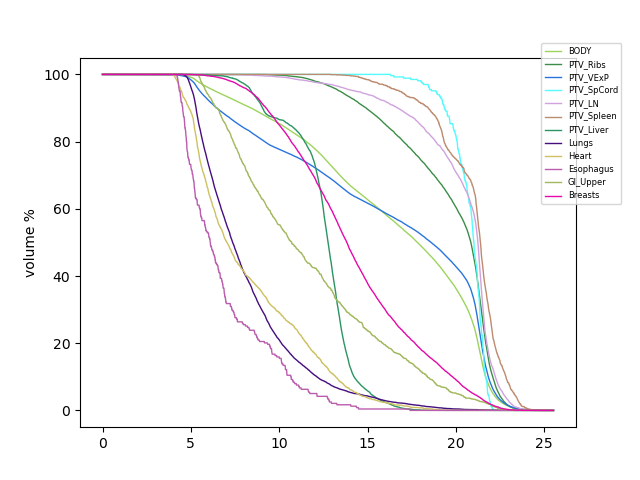

BODY
True mean organ dose is:  16.473467
True max organ dose is:  24.863926
PTV_Ribs
True mean organ dose is:  19.825766
True max organ dose is:  24.428602
PTV_VExP
True mean organ dose is:  16.30895
True max organ dose is:  24.863926
PTV_SpCord
True mean organ dose is:  20.6247
True max organ dose is:  22.969906
PTV_LN
True mean organ dose is:  20.408178
True max organ dose is:  24.292755
PTV_Spleen
True mean organ dose is:  20.93854
True max organ dose is:  23.768955
PTV_Liver
True mean organ dose is:  12.509023
True max organ dose is:  18.288624
Lungs
True mean organ dose is:  8.33166
True max organ dose is:  24.141691
Heart
True mean organ dose is:  8.3424
True max organ dose is:  19.338568
Esophagus
True mean organ dose is:  6.553799
True max organ dose is:  16.260809
GI_Upper
True mean organ dose is:  11.660431
True max organ dose is:  23.425936
Breasts
True mean organ dose is:  14.050295
True max organ dose is:  23.621222


<IPython.core.display.Javascript object>


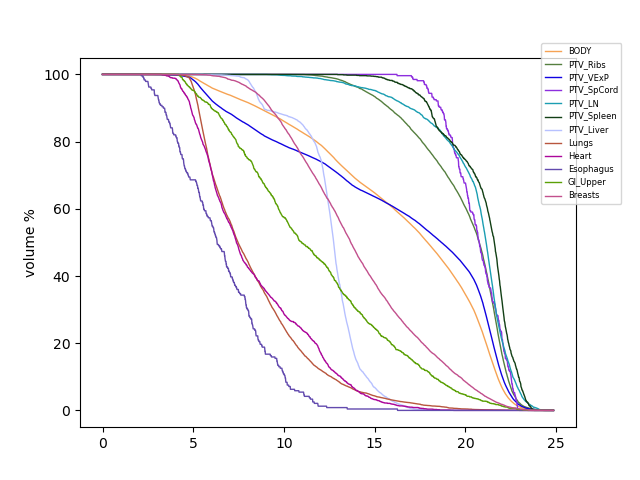

<IPython.core.display.Javascript object>


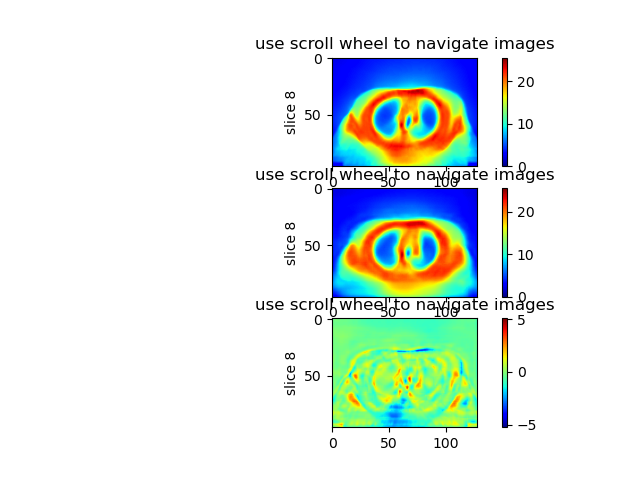

<IPython.core.display.Javascript object>


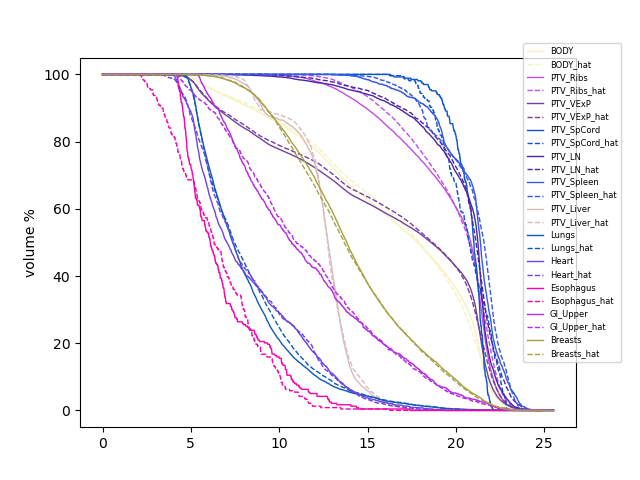

,Organ,Dmean,Dmax,D95,D98,D5,D2
0,BODY,0.005130,-0.026375,0.010623,0.003761,0.003998,-0.000075
1,PTV_Ribs,0.014569,0.000039,0.078207,0.106204,0.009090,0.007912
2,PTV_VExP,0.011048,0.001431,0.009686,0.000535,0.008837,0.004171
3,PTV_SpCord,-0.005491,0.038296,-0.035056,-0.027768,0.039789,0.040460
4,PTV_LN,0.009530,-0.015343,0.051585,0.101734,0.015266,0.014999
5,PTV_Spleen,0.002527,-0.028291,0.021715,0.052922,-0.003422,-0.006376
6,PTV_Liver,0.005914,-0.014625,-0.001258,0.044435,0.012964,0.003501
7,Lungs,0.019431,0.040384,-0.004358,-0.003496,0.022394,0.004006
8,Heart,0.012553,-0.001745,-0.009684,-0.014609,-0.011727,-0.031687
9,Esophagus,-0.046434,-0.065090,-0.377565,-0.444888,-0.054979,-0.099277


work on test patient  patient_2
BODY
True mean organ dose is:  15.39136
True max organ dose is:  28.23615
PTV_Ribs
True mean organ dose is:  16.49697
True max organ dose is:  26.2508
PTV_VExP
True mean organ dose is:  19.24489
True max organ dose is:  27.286682
PTV_SpCord
True mean organ dose is:  19.529453
True max organ dose is:  21.991417
PTV_LN
True mean organ dose is:  17.38732
True max organ dose is:  27.49138
PTV_Spleen
True mean organ dose is:  19.699053
True max organ dose is:  21.919924
PTV_Liver
True mean organ dose is:  13.558965
True max organ dose is:  22.333504
Lungs
True mean organ dose is:  10.978504
True max organ dose is:  24.967419
Heart
True mean organ dose is:  7.664198
True max organ dose is:  21.178871
Esophagus
True mean organ dose is:  15.669184
True max organ dose is:  24.95899
GI_Upper
True mean organ dose is:  16.53762
True max organ dose is:  22.935917
Breasts  not exist


<IPython.core.display.Javascript object>


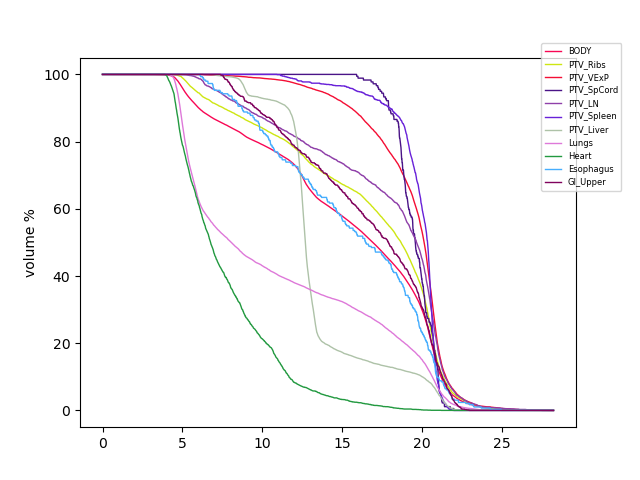

BODY
True mean organ dose is:  15.445033
True max organ dose is:  27.067019
PTV_Ribs
True mean organ dose is:  16.536652
True max organ dose is:  25.769474
PTV_VExP
True mean organ dose is:  19.291096
True max organ dose is:  26.475204
PTV_SpCord
True mean organ dose is:  20.574055
True max organ dose is:  22.66939
PTV_LN
True mean organ dose is:  17.350706
True max organ dose is:  24.672892
PTV_Spleen
True mean organ dose is:  20.161123
True max organ dose is:  23.039562
PTV_Liver
True mean organ dose is:  13.758834
True max organ dose is:  23.263357
Lungs
True mean organ dose is:  11.002479
True max organ dose is:  24.639917
Heart
True mean organ dose is:  7.8926067
True max organ dose is:  20.114843
Esophagus
True mean organ dose is:  15.75727
True max organ dose is:  24.520903
GI_Upper
True mean organ dose is:  16.830898
True max organ dose is:  23.201914
Breasts  not exist


<IPython.core.display.Javascript object>


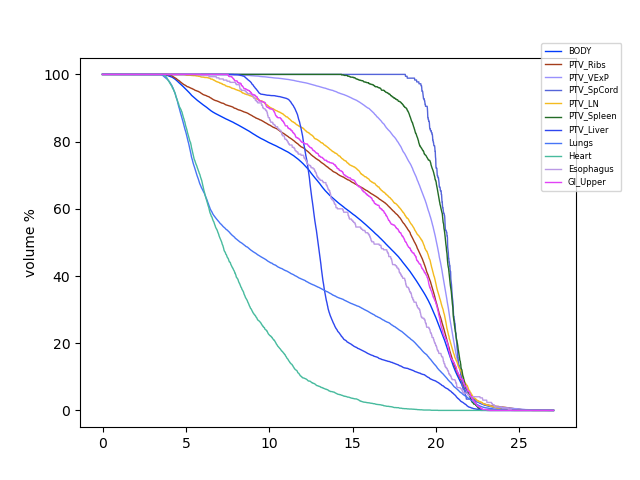

<IPython.core.display.Javascript object>


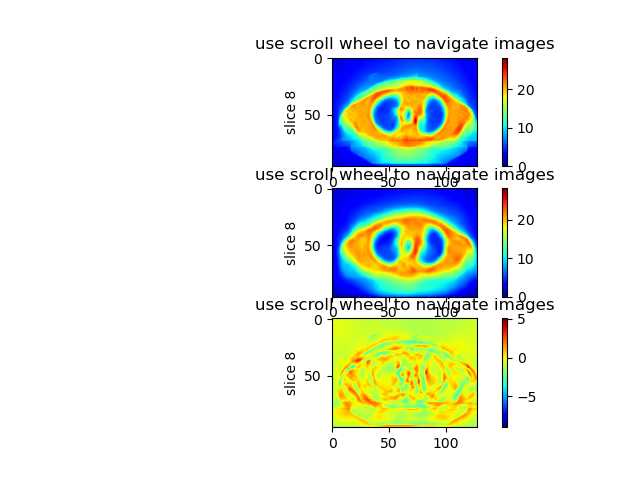

<IPython.core.display.Javascript object>


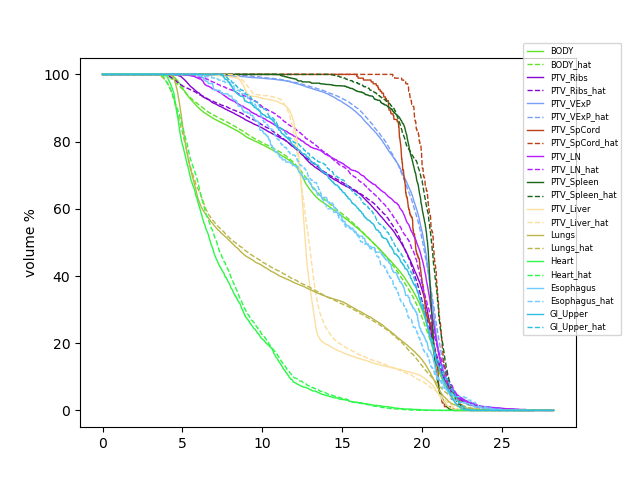

,Organ,Dmean,Dmax,D95,D98,D5,D2
0,BODY,0.003487,-0.041406,-0.001794,-0.047146,0.003887,-0.008310
1,PTV_Ribs,0.002405,-0.018336,-0.025236,-0.111547,0.001691,-0.012144
2,PTV_VExP,0.002401,-0.029739,0.023163,0.010220,-0.010247,-0.017470
3,PTV_SpCord,0.053489,0.030829,0.102656,0.121177,0.028985,0.053436
4,PTV_LN,-0.002106,-0.102523,0.143948,0.079227,0.000219,-0.015718
5,PTV_Spleen,0.023456,0.051079,0.061331,0.275549,0.039332,0.037426
6,PTV_Liver,0.014741,0.041635,0.036970,0.019482,0.002401,0.011569
7,Lungs,0.002184,-0.013117,-0.079054,-0.119291,0.016633,0.024811
8,Heart,0.029802,-0.050240,-0.026092,-0.047904,0.031110,-0.009232
9,Esophagus,0.005622,-0.017552,0.164665,0.155337,-0.002114,0.026428


work on test patient  patient_3
BODY
True mean organ dose is:  15.483254
True max organ dose is:  25.42727
PTV_Ribs
True mean organ dose is:  18.94304
True max organ dose is:  24.134563
PTV_VExP
True mean organ dose is:  14.711557
True max organ dose is:  25.42727
PTV_SpCord
True mean organ dose is:  20.021742
True max organ dose is:  21.200737
PTV_LN
True mean organ dose is:  19.629684
True max organ dose is:  23.052628
PTV_Spleen
True mean organ dose is:  20.599417
True max organ dose is:  21.726841
PTV_Liver
True mean organ dose is:  12.514458
True max organ dose is:  16.39862
Lungs
True mean organ dose is:  8.107888
True max organ dose is:  22.50711
Heart
True mean organ dose is:  7.015418
True max organ dose is:  19.914865
Esophagus
True mean organ dose is:  6.2188964
True max organ dose is:  16.30576
GI_Upper
True mean organ dose is:  10.074879
True max organ dose is:  19.3943
Breasts
True mean organ dose is:  20.119835
True max organ dose is:  23.429369


<IPython.core.display.Javascript object>


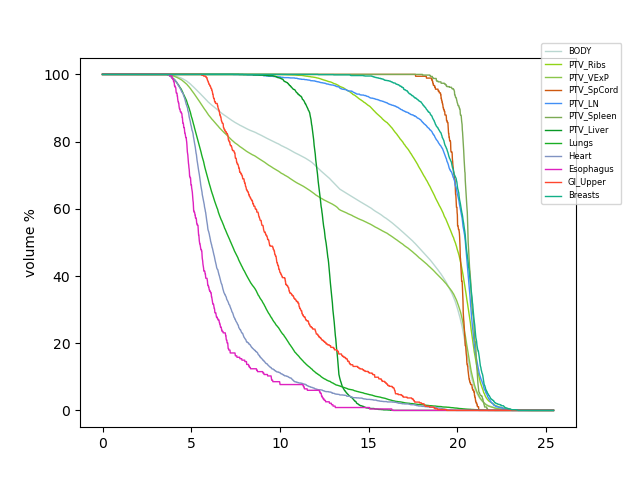

BODY
True mean organ dose is:  15.517399
True max organ dose is:  24.481026
PTV_Ribs
True mean organ dose is:  18.903738
True max organ dose is:  23.433939
PTV_VExP
True mean organ dose is:  14.7988
True max organ dose is:  24.481026
PTV_SpCord
True mean organ dose is:  20.404503
True max organ dose is:  23.18059
PTV_LN
True mean organ dose is:  19.813402
True max organ dose is:  23.321173
PTV_Spleen
True mean organ dose is:  21.005077
True max organ dose is:  23.929947
PTV_Liver
True mean organ dose is:  12.574654
True max organ dose is:  17.093128
Lungs
True mean organ dose is:  8.309041
True max organ dose is:  23.722128
Heart
True mean organ dose is:  6.925566
True max organ dose is:  18.920252
Esophagus
True mean organ dose is:  6.7601414
True max organ dose is:  16.71358
GI_Upper
True mean organ dose is:  10.292518
True max organ dose is:  18.733845
Breasts
True mean organ dose is:  19.801445
True max organ dose is:  23.433939


<IPython.core.display.Javascript object>


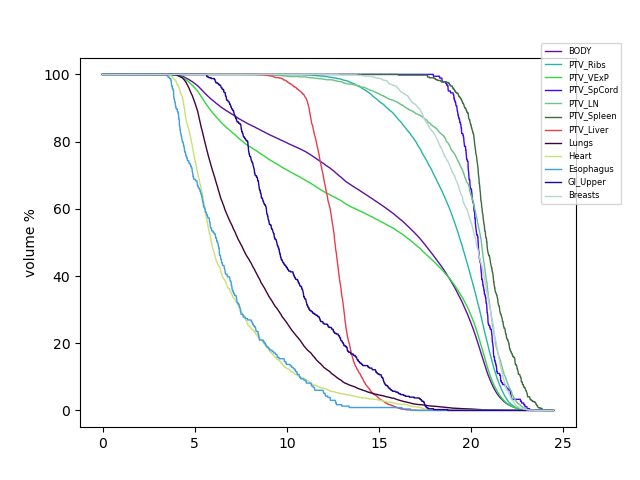

<IPython.core.display.Javascript object>


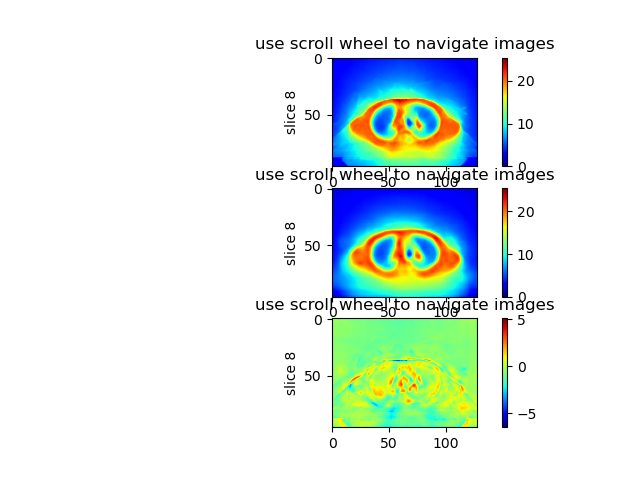

<IPython.core.display.Javascript object>


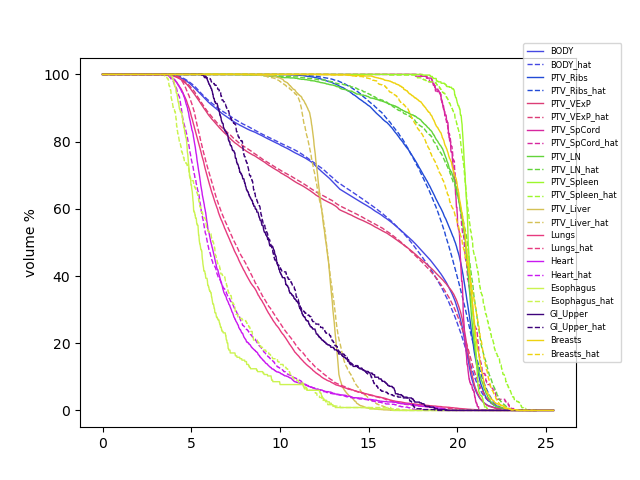

,Organ,Dmean,Dmax,D95,D98,D5,D2
0,BODY,0.002205,-0.037214,0.017542,0.014410,0.014405,0.017284
1,PTV_Ribs,-0.002075,-0.029030,0.032438,0.050752,0.011722,0.005614
2,PTV_VExP,0.005930,-0.037214,0.020844,0.016724,0.016628,0.019588
3,PTV_SpCord,0.019117,0.093386,-0.008097,-0.008916,0.058129,0.080228
4,PTV_LN,0.009359,0.011649,0.057125,0.063971,0.027312,0.026267
5,PTV_Spleen,0.019693,0.101400,-0.035362,-0.033966,0.083710,0.093739
6,PTV_Liver,0.004810,0.042352,-0.014719,-0.025254,0.064927,0.074401
7,Lungs,0.024810,0.053984,0.060974,0.087592,-0.008289,-0.037214
8,Heart,-0.012808,-0.049943,-0.053719,-0.034251,-0.011016,-0.053914
9,Esophagus,0.087032,0.025011,-0.069700,-0.073891,-0.022248,-0.009460


In [14]:
predict_unit_test()